In [2]:
import xarray as xr
import numpy as np
import os
import matplotlib.pyplot as plt
import gsw
from datetime import datetime, timedelta
import pandas as pd
import importlib
from gptide import GPtideScipy
from gptide import stats as gpstats
from scipy import signal as sg
import scipy
from speccy import utils as ut
from scipy import stats
from speccy import sick_tricks as gary
from scipy.special import kv as K_nu
from scipy.special import gamma
from scipy.optimize import minimize
from collections import defaultdict
# mle function import
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
from functions import GP
from functions import Cov
from functions import Harmonics
from functions import Skill
from functions import Processing
from functions import Plot_figure

d2spike not available
pyODAS not found, not importing pIMOS.xrwrap.rsi_vmp
No .afloatconfig config file found!


In [4]:
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['font.size'] = 12
plt.rcParams['figure.figsize'] = [20, 10]
#np.set_printoptions(threshold=sys.maxsize)
plt.rcParams['animation.embed_limit'] = 2**128

# Import the Internal Wave Displacement Data

Referring to notebook of Paper 2 for how to estimate the internal wave displacement from the temperature depth profile.

In [7]:
from functions import Processing
importlib.reload(Processing)
# Please store the downloaded estimated displacement in the same folder of this notebook 
# Read estimated displacement data 
ds_dictionary,A_n_dict,Time_dict, Start_date_dict = Processing.Read_PL3_data('PL3 Stacked data_mode_3 - density fit - single_tanh',      
                                                                   percentage=0.80,do_windowing=False,window_size_days=80)
Site_names,Lat_list,Lon_list = Processing.Extract_site_info(ds_dictionary)

There are 19 raw PL3 data (no windowing)
NWSBAR_P5 has over-fitting 111.8680746438446%
NWSBAR_P9 has over-fitting 100.40775261969844%
NWSBAR_P0 mode 3 has 137 amplitudes > 100m. Setting them to NaN.
NWSBAR_P1 mode 1 has 72 amplitudes > 100m. Setting them to NaN.
NWSBAR_P1 mode 2 has 72 amplitudes > 100m. Setting them to NaN.
NWSBAR_P1 mode 3 has 72 amplitudes > 100m. Setting them to NaN.
NWSBAR_P3 mode 1 has 108 amplitudes > 100m. Setting them to NaN.
NWSBAR_P3 mode 2 has 196 amplitudes > 100m. Setting them to NaN.
NWSBAR_P3 mode 3 has 139 amplitudes > 100m. Setting them to NaN.
NWSBAR_P7 mode 1 has 36 amplitudes > 100m. Setting them to NaN.
NWSBAR_P7 mode 2 has 36 amplitudes > 100m. Setting them to NaN.
NWSBAR_P7 mode 3 has 36 amplitudes > 100m. Setting them to NaN.
NWSBRW_P12 mode 1 has 187 amplitudes > 100m. Setting them to NaN.
NWSBRW_P13 mode 1 has 46 amplitudes > 100m. Setting them to NaN.
NWSBRW_P15 mode 1 has 1 amplitudes > 100m. Setting them to NaN.
NWSBRW_P18 mode 1 has 1 amp

Apply a bandpass filter to extract the internal tide signal

In [9]:
importlib.reload(Processing)
# cpd into second into hz
cutoff_dt = [1/(1.73/86400),1/(2.13/86400)]
A_n_IT_dict = {}
for key, data_list in A_n_dict.items():
    filtered_list = []
    for da in data_list:
        filtered_da = Processing.Filt(da, cutoff_dt, btype='band', order=8, ftype='sos', axis=-1)
        filtered_list.append(filtered_da)
    A_n_IT_dict[key] = filtered_list

The estimated displacement dicts were made of a number of 80-day segments. So we need to aggregate the dicts from the same site and the same year for substantial Harmonic analysis

In [11]:
importlib.reload(Processing)
aggregated_A_n     = Processing.Aggregate_dict_by_site_mode_year(A_n_dict)
aggregated_A_n_IT  = Processing.Aggregate_dict_by_site_mode_year(A_n_IT_dict)
aggregated_Time    = Processing.Aggregate_dict_by_site_mode_year(Time_dict)
aggregated_A_n_IT

{('NWSBAR',
  0,
  2019): <xarray.DataArray (time: 42597)> Size: 341kB
 array([ 0.24669795,  0.30102799,  0.35475351, ..., -2.15611845,
        -1.84905456, -1.53843676])
 Coordinates:
   * time     (time) datetime64[ns] 341kB 2019-08-06T02:15:09.000001536 ... 20...
     lat_nom  float64 8B ...
     lon_nom  float64 8B ...
     modes    int32 4B 0
 Attributes:
     long_name:  Modal buoyancy amplitude
     units:      m,
 ('NWSBAR',
  0,
  2020): <xarray.DataArray (time: 105410)> Size: 843kB
 array([-1.2248242 , -0.90878185, -0.5908794 , ..., -4.14580098,
        -3.94098909, -3.7291111 ])
 Coordinates:
   * time     (time) datetime64[ns] 843kB 2020-01-01T00:00:09.000001536 ... 20...
     lat_nom  (time) float64 843kB -20.76 -20.76 -20.76 ... -20.76 -20.76 -20.76
     lon_nom  (time) float64 843kB 114.8 114.8 114.8 114.8 ... 114.8 114.8 114.8
     modes    int32 4B 0
 Attributes:
     long_name:  Modal buoyancy amplitude
     units:      m,
 ('NWSBAR',
  1,
  2019): <xarray.DataArray (

## Harmonic Analysis (HA) for Phase-locked

 - Apply harmonic analysis to extract the phase-locked component of the semidiurnal internal tides.
 - Then, remove this phase-locked component from the total signal, leaving the residual as the non-phase-locked internal tides (🚩 main focus).
 - Convert the residual time-series signal into a periodogram in the frequency domain. 

In [14]:
# create the dict to store the HA results
Mean_params_dict ={}
Yd_mean_dict ={}
ϵ_dict ={}
F_ϵ_dict ={}
Puu_ϵ_dict ={}
HA_var_dict = {}

for i in aggregated_A_n_IT:
    Mean_params_list, Yd_mean_list,ϵ_list,F_ϵ_list,Puu_ϵ_list = Harmonics.Cal_HA(aggregated_Time[i],aggregated_A_n_IT[i]) #apply on the whole year data
    Mean_params_dict[i] = Mean_params_list 
    Yd_mean_dict[i]     = Yd_mean_list
    ϵ_dict[i]           = ϵ_list
    F_ϵ_dict[i]         = F_ϵ_list
    Puu_ϵ_dict[i]       = Puu_ϵ_list
    #calculate HA var
    HA_var_list     = Harmonics.Cal_var_from_mean_funcs(Yd_mean_list)
    HA_var_dict[i]  = HA_var_list    

Text(0.5, 0, 'Date')

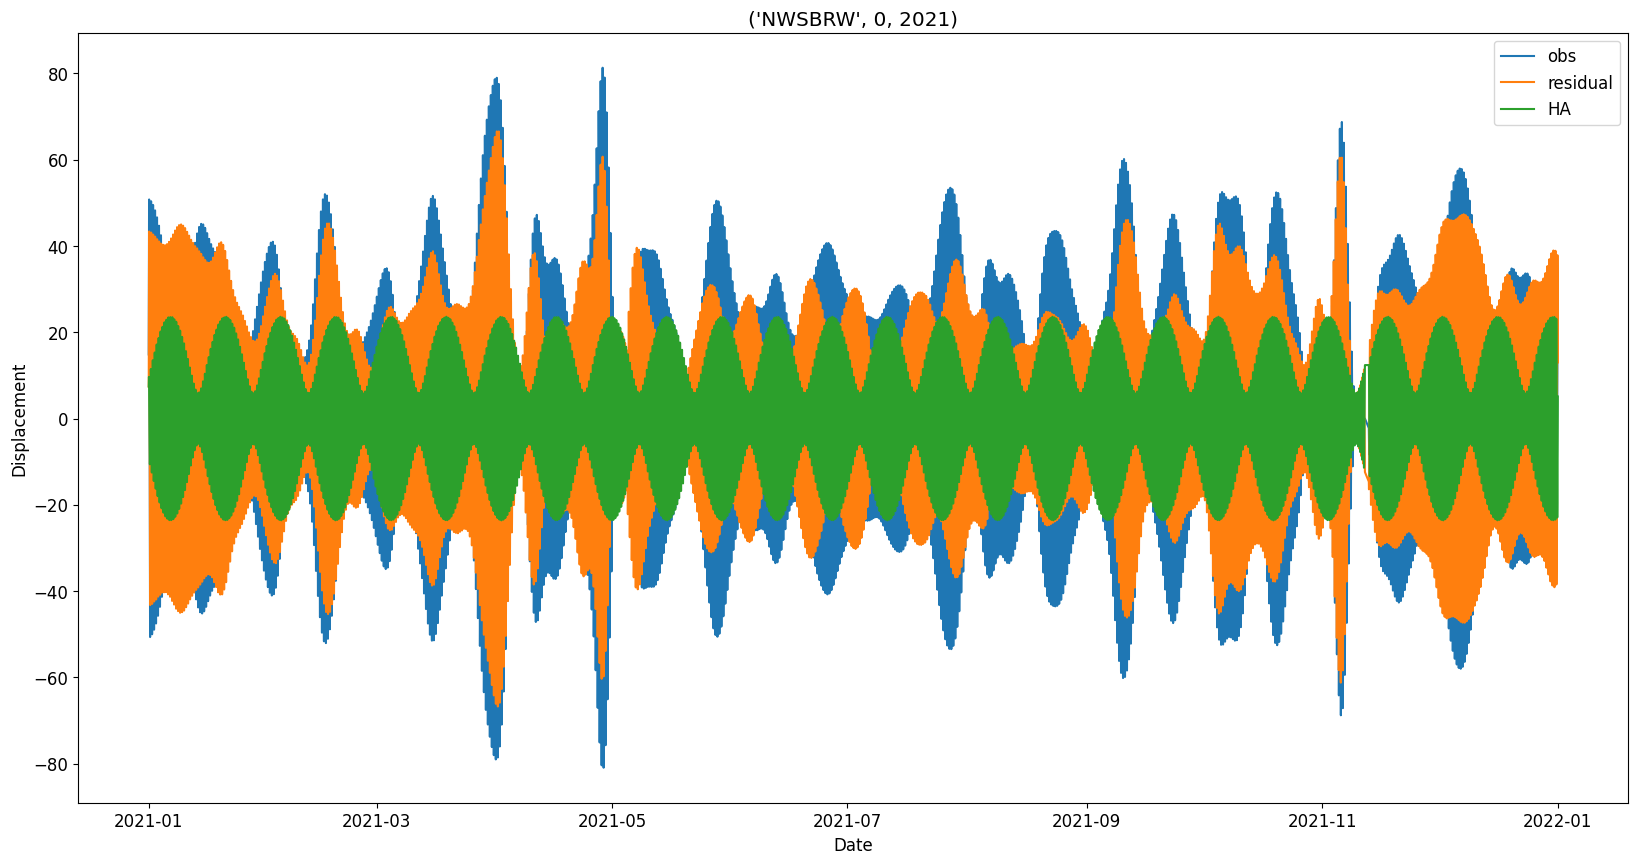

In [15]:
# An example of HA result
obs_name = ('NWSBRW', 0,2021)
plt.plot(aggregated_Time[obs_name],aggregated_A_n_IT[obs_name],label='obs')
plt.plot(aggregated_Time[obs_name],ϵ_dict[obs_name][0],label='residual')
plt.plot(aggregated_Time[obs_name],Yd_mean_dict[obs_name][0],label='HA')
plt.title(obs_name)
plt.legend()
plt.ylabel('Displacement')
plt.xlabel('Date')

## Parameterization P1 and P2 for Non-phase-locked

 - See Paper 2 notebook for details on estimating parameters using Whittle likelihood for the non-phase-locked internal tides.
 - After reading the parameters set, we need to clean up the parameters to avoid the bad-fits. The cleaning strategy was detailed in the "Clean-up" function
 - From the parameters, we can easily estimate the integral timescale and the variance of each part of spectrum


### P2

In [19]:
# Read the optimized parameters
Final_df_P2_all = pd.read_csv('NPL IT P2 Model fit parameters from displacement mode_3 - density fit - single_tanh.csv') 
#select the example site NWSBRW
Final_df_P2_all = Processing.Select_df_from_sites(Final_df_P2_all,['NWSBRW'],'P2')  
Drop_df_P2, Final_df_P2_clean = Processing.Clean_and_Process_DF(Final_df_P2_all)

0(0.0%) of 51 fits are removed


In [20]:
importlib.reload(Processing)
P2_parameter_name = [ 'η_S2','T_S2','η_M2','T_M2',]
# medium_T_P2 represents the integral timescale estimated from η, τ and γ
medium_std_P2, medium_T_P2 =  Processing.Calc_Parameter_medium_and_std(Final_df_P2_clean, P2_parameter_name,by_mode=True)
P2_parameter_name = ['η_S2','τ_S2','γ_S2','η_M2','τ_M2','γ_M2',]
# medium_τ_P2 represents the raw parameter
medium_std_P2, medium_τ_P2 =  Processing.Calc_Parameter_medium_and_std(Final_df_P2_clean, P2_parameter_name,by_mode=True)
medium_T_P2

η_S2      T_S2      η_M2      T_M2
Site   Mode                                            
NWSBRW 1     3.691918e+00  5.293562  8.773780  4.620074
       2     1.300000e-09  0.003472  3.638156  2.790132
       3     1.561000e-07  6.202191  2.825420  2.974129

### P1

In [22]:
Final_df_P1_all = pd.read_csv('NPL IT P1 Model fit parameters from displacement mode_3 - density fit - single_tanh.csv') 
Final_df_P1_all = Processing.Select_df_from_sites(Final_df_P1_all,['NWSBRW'],'P1')
Drop_df_P1, Final_df_P1_clean = Processing.Clean_and_Process_DF(Final_df_P1_all)

0(0.0%) of 51 fits are removed


In [23]:
P1_parameter_name = ['η_D2','T_D2']
medium_std_P1, medium_T_P1 = Processing.Calc_Parameter_medium_and_std(Final_df_P1_clean, P1_parameter_name,by_mode=True)
P1_parameter_name = ['η_D2','τ_D2','γ_D2',]
medium_std_P1, medium_τ_P1 = Processing.Calc_Parameter_medium_and_std(Final_df_P1_clean, P1_parameter_name,by_mode=True)
medium_T_P1

η_D2      T_D2
Site   Mode                    
NWSBRW 1     9.532348  3.769459
       2     3.781127  2.581588
       3     3.061791  2.758773

# NPL GP Prediction - An example at NWSBRW

In [25]:
# define the P1 and P2 parameterization
def P2_GP(x,xpr,params):
    #params: 'η_S2','τ_S2','γ_S2','η_M2','τ_M2','γ_M2',
    dx = np.abs(x-xpr)
    S2_freq = 1.93 #cpd
    M2_freq = 2 #cpd
    return  Cov.LR_2(dx,params[0:3],l_cos=S2_freq) + Cov.LR_2(dx,params[3:6],l_cos=M2_freq)

def P1_GP(x,xpr,params):
    #params: 'η_D2','τ_D2','γ_D2'
    dx = np.abs(x-xpr)  
    S2_freq = 1.93 #cpd
    M2_freq = 2 #cpd
    D2_freq = (S2_freq+M2_freq)/2
    return  Cov.LR_2(dx,params[0:3],l_cos=D2_freq)

# Only NPL signal so zero-mean
mean_func = None
mean_params =  None

## Read Site Observation

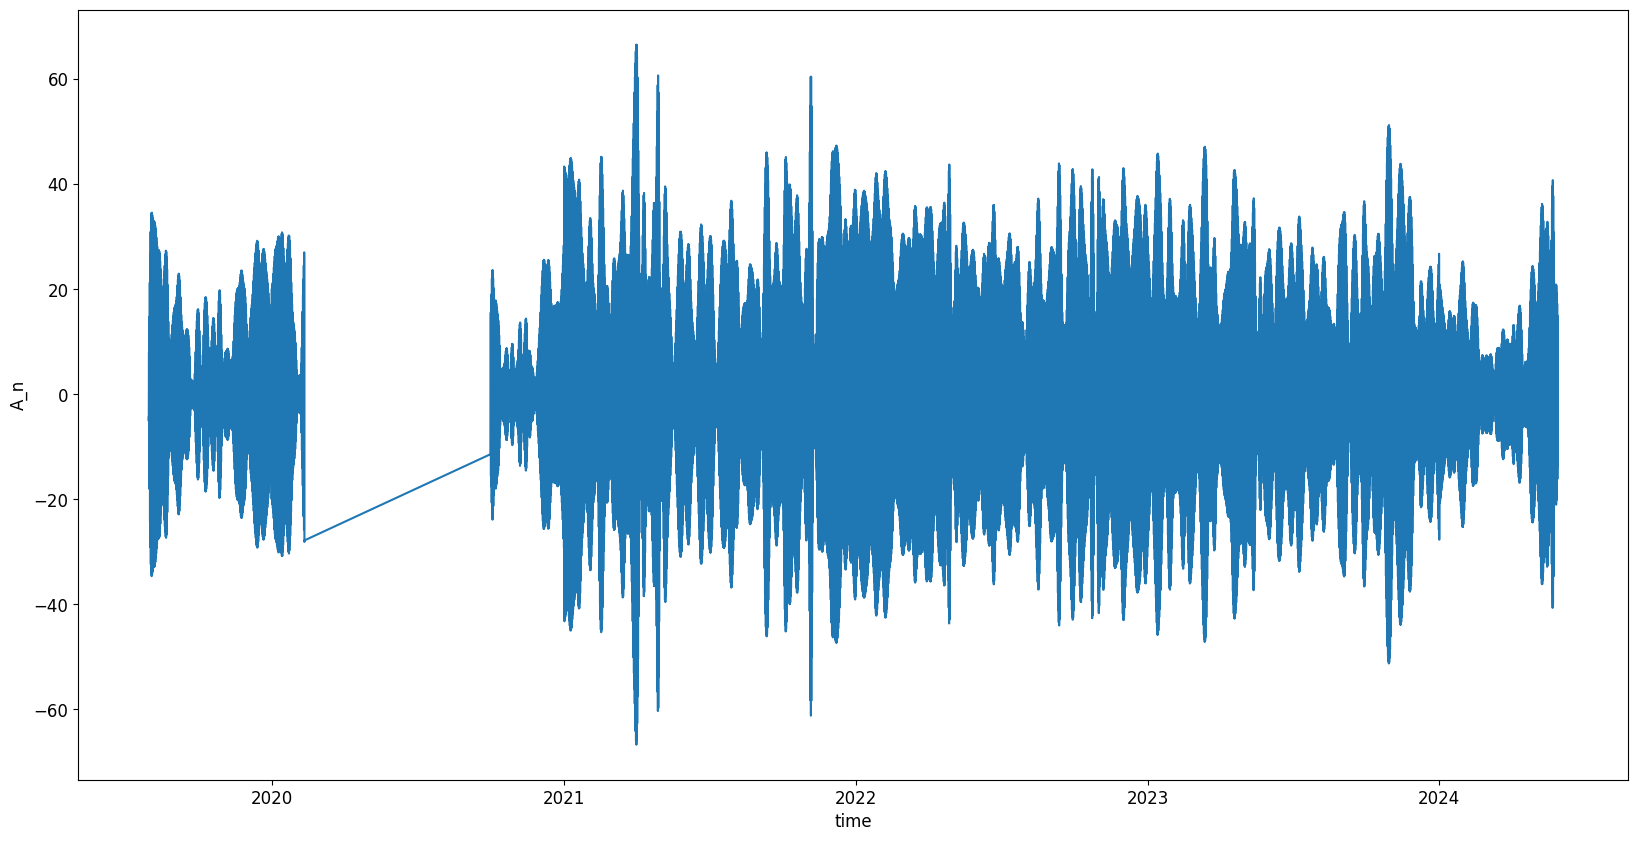

In [27]:
# Select the data from NWSBRW as an example
A_obs_NWSBRW =  Processing.Read_aggregared_data(ϵ_dict,aggregated_Time,'NWSBRW',0)
A_obs_NWSBRW.plot()

## Extract Random Samples from the Site Observations

In [47]:
# Extract random samples, each with a length of 35 days.
# 'overlap' is the maximum percentage of overlapping days allowed between any two samples.
sample_NWSBRW =  GP.Extract_nonoverlapping_samples(A_obs_NWSBRW,sample_duration_days=35, 
                                         max_overlap_fraction=0.25, max_nan_fraction=0.1,
                                         max_samples=200, seed=None)
# for i in samples:
#     plt.subplots(figsize=(12, 5))
#     plt.plot(i)

Max allowed overlap: 8.8 days (756000.0 s)
Expected points per sample: 10080 (based on 288 samples/day)
Attempting to extract up to 200 samples...

Checking window: 2020-11-06T10:58:04.000001536 to 2020-12-11T10:58:04.000001536 | Points: 10080
  → NaN fraction: 0.00%
  ✓ Overlap check passed.
  ✓ Constant sampling frequency: 300 s
  ✅ Sample accepted.

Checking window: 2023-08-29T07:19:56.000001536 to 2023-10-03T07:19:56.000001536 | Points: 10080
  → NaN fraction: 0.00%
  ✓ Overlap check passed.
  ✓ Constant sampling frequency: 300 s
  ✅ Sample accepted.

Checking window: 2020-04-29T04:30:15.000001536 to 2020-06-03T04:30:15.000001536 | Points: 0
  ❌ Too few data points.

Checking window: 2022-04-14T23:30:35.000001536 to 2022-05-19T23:30:35.000001536 | Points: 10081
  → NaN fraction: 0.00%
  ✓ Overlap check passed.
  ❌ Inconsistent sampling interval — rejected.

Checking window: 2021-09-12T00:29:13.000001536 to 2021-10-17T00:29:13.000001536 | Points: 10080
  → NaN fraction: 0.00%
  ✓ Ov

### P2

In [49]:
#import the P2 parameters
NWSBRW_covparams = list(medium_τ_P2.loc[("NWSBRW", 1)]) #mode 0
NWSBRW_covparams #'η_S2','τ_S2','γ_S2','η_M2','τ_M2','γ_M2'

[3.6919179685,
 5.2080719324,
 1.2061654637,
 8.7737796325,
 5.1592992361,
 1.7791236988]

#### 21-day

In [53]:
# Prediction Set-up 
obs_length = 6000    # ~ 21 days
total_length = 10000 # ~ 35 day
frequency_scale  = 1 # no scale
sample_number = 25   # number of prediction sample

the observation period is 20.833333333333332 days
prediction interval is 300.0 s
the prediction is for 13.88888888888889 days
the prediction is the 99 samples of the posterior + mean
Prediction is done


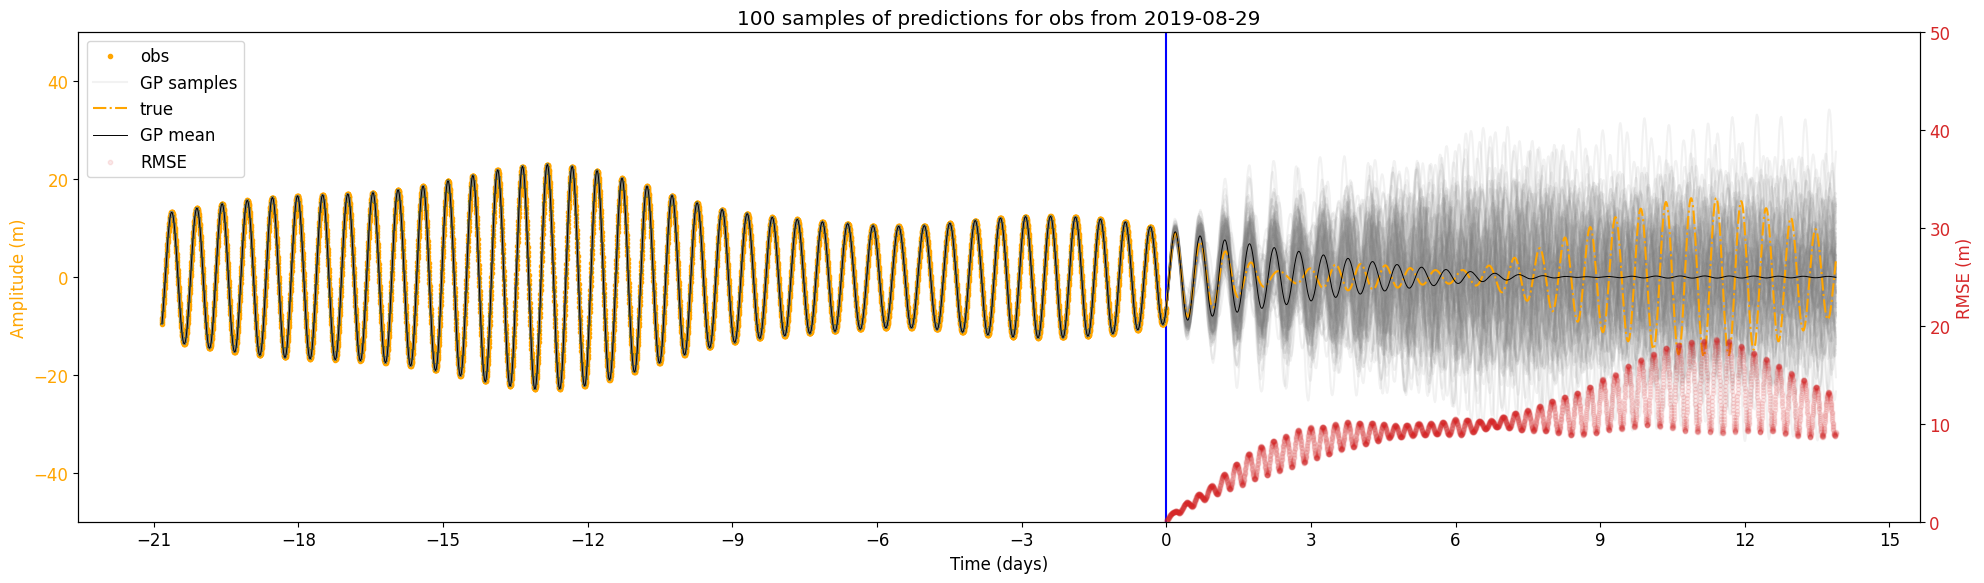

In [54]:
# select an example from the random samples
A_obs = sample_NWSBRW[10]
x_obs_21,y_obs_21,x_true_21,y_true_21, GP_P2_predict_dataset_21 = GP.Predicting(A_obs, obs_length, total_length,
                                                                   NWSBRW_covparams,P2_GP, mean_func,mean_params,
                                                                   sample_number= 100, noise = 0,freq_scale=frequency_scale)
# Plot the Prediction with RMSE
Plot_figure.Plot_predictions_with_RMSE(GP_P2_predict_dataset_21,x_obs_21,y_obs_21,x_true_21,y_true_21,
                                       amplitude_ylim=(-50, 50), figsize=(20, 6))

#ax1.set_xlim(-0.1,7)
plt.show()

In [57]:
#repeat for all random samples
SE_list_NWSBRW_P2_21 = []
DSS_list_NWSBRW_P2_21 = []
CRPS_list_NWSBRW_P2_21 = []
for A_obs in sample_NWSBRW:
    try:
        x_obs_21, y_obs_21, x_true_21, y_true_21, GP_P2_predict_dataset_21 = GP.Predicting(A_obs, obs_length, total_length,
                                                                              NWSBRW_covparams, P2_GP, mean_func, mean_params,
                                                                              sample_number=50, noise=0, freq_scale=frequency_scale )
        if GP_P2_predict_dataset_21 is not None:
            # compute three different skill scores
            SE_list = Skill.Cal_skill(y_true_21,x_obs_21,GP_P2_predict_dataset_21,skill_type='SE')
            SE_list_NWSBRW_P2_21.append(SE_list)
            DSS_List = Skill.Cal_skill(y_true_21,x_obs_21,GP_P2_predict_dataset_21,skill_type='DSS')
            DSS_list_NWSBRW_P2_21.append(DSS_List)
            CRPS_List = Skill.Cal_skill(y_true_21,x_obs_21,GP_P2_predict_dataset_21,skill_type='CRPS')
            CRPS_list_NWSBRW_P2_21.append(CRPS_List)  
            # Plot_figure.Plot_predictions_with_RMSE(GP_P2_predict_dataset_21,x_obs_21, y_obs_21, x_true_21, y_true_21,
            #                            amplitude_ylim=(-75, 75), figsize=(20, 6))
        else:
            print('Predictions are completed and stop')
            
    except Exception as e:
        print(f"Skipping obs_start_idx due to error: {e}")

the observation period is 20.833333333333332 days
prediction interval is 300.0 s
the prediction is for 13.88888888888889 days
the prediction is the 49 samples of the posterior + mean
Prediction is done
the observation period is 20.833333333333332 days
prediction interval is 300.0 s
the prediction is for 13.88888888888889 days
the prediction is the 49 samples of the posterior + mean
Bad prediction: MAE = 13.33, Max Error = 36.62 (threshold 35)
Predictions are completed and stop
the observation period is 20.833333333333332 days
prediction interval is 300.0 s
the prediction is for 13.88888888888889 days
the prediction is the 49 samples of the posterior + mean
Bad prediction: MAE = 19.47, Max Error = 42.76 (threshold 35)
Predictions are completed and stop
the observation period is 20.833333333333332 days
prediction interval is 300.0 s
the prediction is for 13.88888888888889 days
the prediction is the 49 samples of the posterior + mean
Prediction is done
the observation period is 20.8333333

#### 14-day

the observation period is 13.888888888888888 days
prediction interval is 300.0 s
the prediction is for 13.888888888888888 days
the prediction is the 99 samples of the posterior + mean
Prediction is done


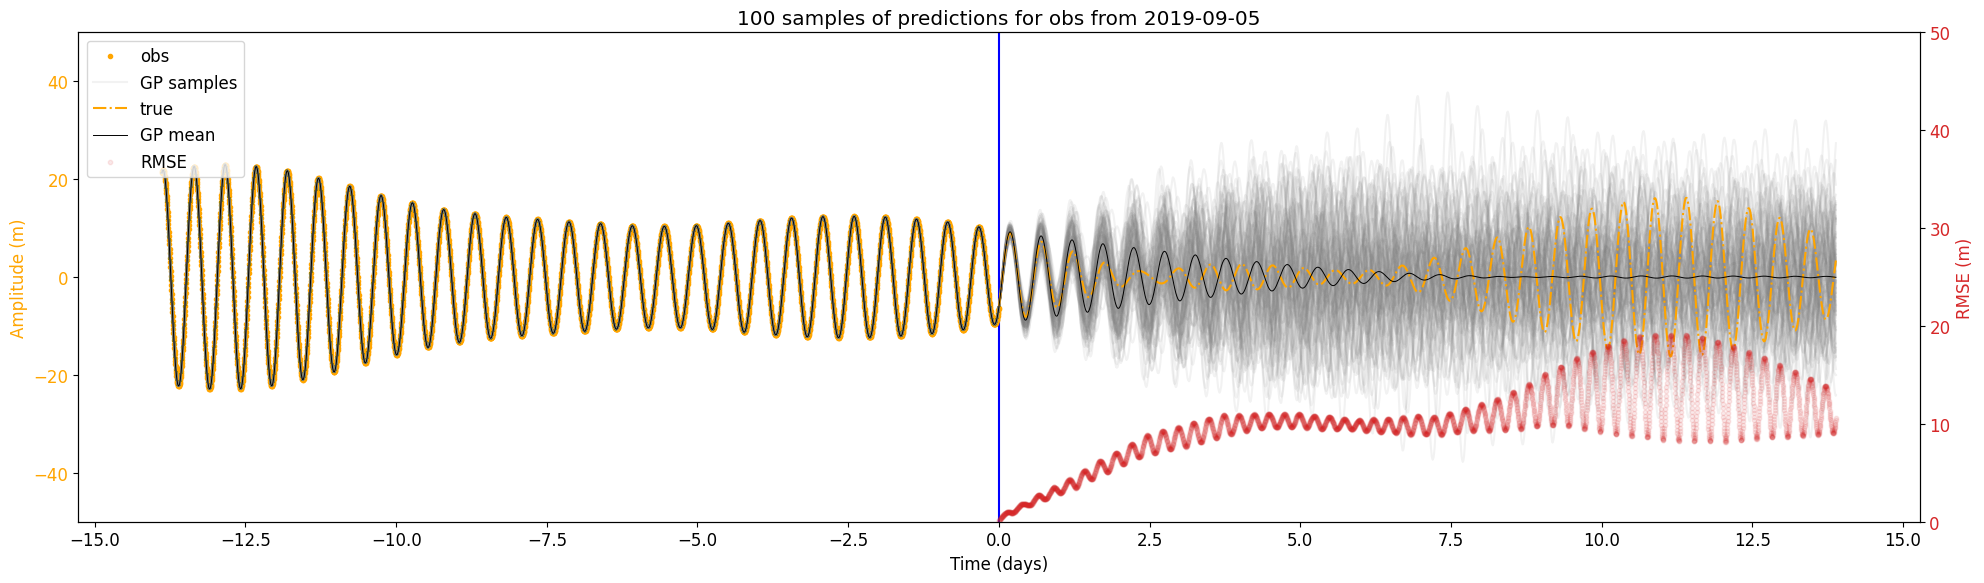

In [59]:
# prediction set up
A_obs = sample_NWSBRW[10]
obs_length = 4000 # 
total_length = 10000
total_length = total_length - 2000
x_obs_14,y_obs_14,x_true_14,y_true_14, GP_P2_predict_dataset_14 = GP.Predicting(A_obs[2000:], obs_length, total_length,
                                                                   NWSBRW_covparams,P2_GP, mean_func,mean_params,
                                                                   sample_number= 100, noise = 0,error_threshold=100, freq_scale=frequency_scale)
# Plot the Prediction with RMSE
Plot_figure.Plot_predictions_with_RMSE(GP_P2_predict_dataset_14,x_obs_14,y_obs_14,x_true_14,y_true_14,
                                       amplitude_ylim=(-50, 50), figsize=(20, 6))
plt.show()

In [60]:
#repeat for all 
SE_list_NWSBRW_P2_14 = []
DSS_list_NWSBRW_P2_14 = []
CRPS_list_NWSBRW_P2_14 = []
for A_obs in sample_NWSBRW:
    try:
        x_obs_14, y_obs_14, x_true_14, y_true_14, GP_P2_predict_dataset_14 = GP.Predicting(A_obs[2000:], obs_length, total_length,
                                                                              NWSBRW_covparams, P2_GP, mean_func, mean_params,
                                                                              sample_number=50, noise=0, freq_scale=frequency_scale )
        if GP_P2_predict_dataset_14 is not None:
            SE_list = Skill.Cal_skill(y_true_14,x_obs_14,GP_P2_predict_dataset_14,skill_type='SE')
            SE_list_NWSBRW_P2_14.append(SE_list)
            DSS_List = Skill.Cal_skill(y_true_14,x_obs_14,GP_P2_predict_dataset_14,skill_type='DSS')
            DSS_list_NWSBRW_P2_14.append(DSS_List)
            CRPS_List = Skill.Cal_skill(y_true_14,x_obs_14,GP_P2_predict_dataset_14,skill_type='CRPS')
            CRPS_list_NWSBRW_P2_14.append(CRPS_List)  
            # Plot_figure.Plot_predictions_with_RMSE(GP_P2_predict_dataset_14,x_obs_14, y_obs_14, x_true_14, y_true_14,
            #                            amplitude_ylim=(-75, 75), figsize=(20, 6))
        else:
            print('Predictions are completed and stop')
            
    except Exception as e:
        print(f"Skipping obs_start_idx due to error: {e}")

the observation period is 13.888888888888888 days
prediction interval is 300.0 s
the prediction is for 13.888888888888888 days
the prediction is the 49 samples of the posterior + mean
Prediction is done
the observation period is 13.888888888888888 days
prediction interval is 300.0 s
the prediction is for 13.888888888888888 days
the prediction is the 49 samples of the posterior + mean
Bad prediction: MAE = 13.33, Max Error = 36.62 (threshold 35)
Predictions are completed and stop
the observation period is 13.888888888888888 days
prediction interval is 300.0 s
the prediction is for 13.888888888888888 days
the prediction is the 49 samples of the posterior + mean
Bad prediction: MAE = 19.47, Max Error = 42.76 (threshold 35)
Predictions are completed and stop
the observation period is 13.888888888888888 days
prediction interval is 300.0 s
the prediction is for 13.888888888888888 days
the prediction is the 49 samples of the posterior + mean
Prediction is done
the observation period is 13.888

#### 7-day

the observation period is 6.944444444444444 days
prediction interval is 300.0 s
the prediction is for 13.88888888888889 days
the prediction is the 99 samples of the posterior + mean
Prediction is done


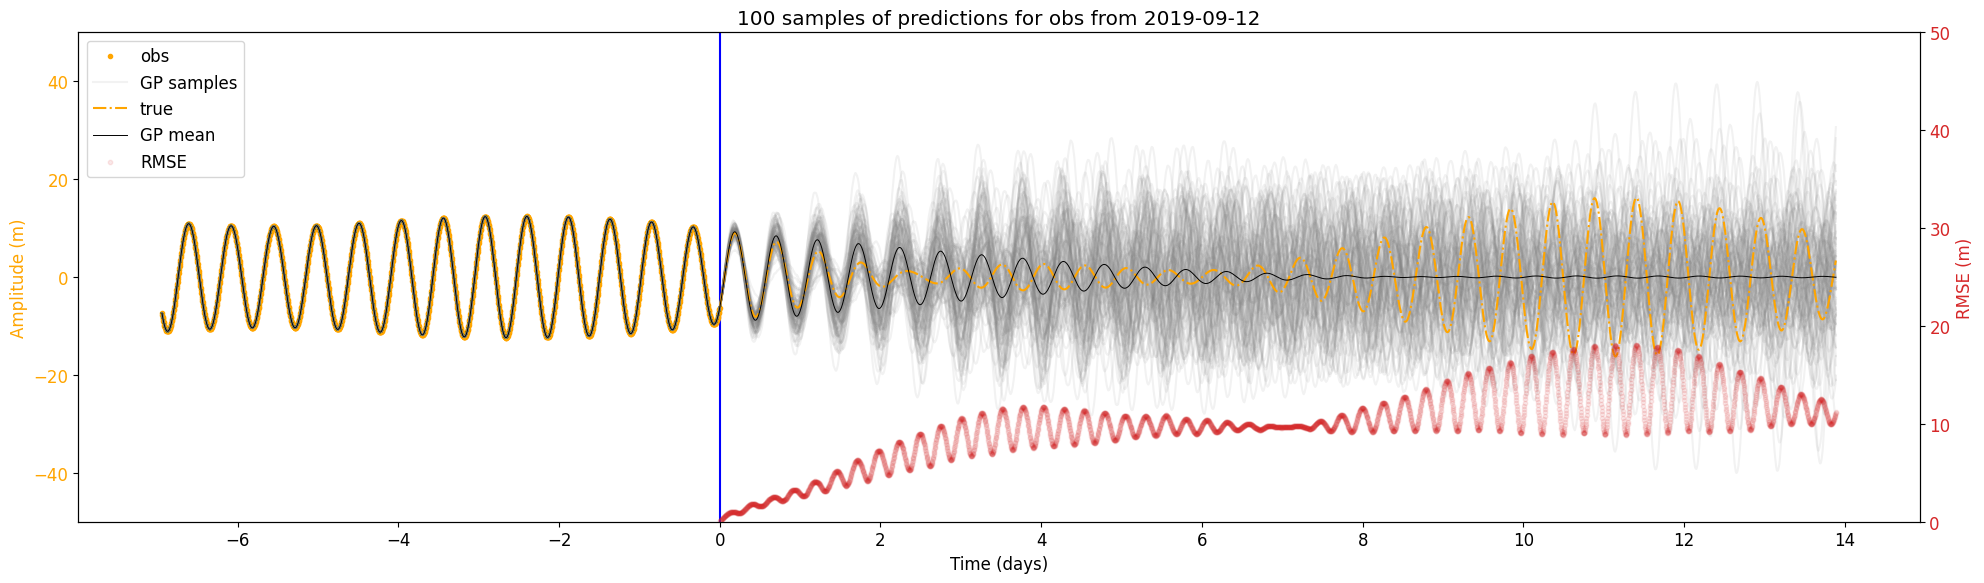

In [62]:
A_obs = sample_NWSBRW[10]
obs_length = 2000 # ~7 days
total_length = 10000
total_length = total_length - 4000
x_obs_7,y_obs_7,x_true_7,y_true_7, GP_P2_predict_dataset_7 = GP.Predicting(A_obs[4000:], obs_length, total_length,
                                                                   NWSBRW_covparams,P2_GP, mean_func,mean_params,
                                                                   sample_number= 100, noise = 0,error_threshold=100, freq_scale=frequency_scale)
# Plot the Prediction with RMSE
Plot_figure.Plot_predictions_with_RMSE(GP_P2_predict_dataset_7,x_obs_7,y_obs_7,x_true_7,y_true_7,
                                       amplitude_ylim=(-50, 50), figsize=(20, 6))
plt.show()

In [63]:
#repeat for all 
SE_list_NWSBRW_P2_7 = []
DSS_list_NWSBRW_P2_7 = []
CRPS_list_NWSBRW_P2_7 = []
for A_obs in sample_NWSBRW:
    try:
        x_obs_7,y_obs_7,x_true_7,y_true_7, GP_P2_predict_dataset_7 = GP.Predicting(A_obs[4000:], obs_length, total_length,
                                                                              NWSBRW_covparams, P2_GP, mean_func, mean_params,
                                                                              sample_number=50, noise=0, freq_scale=frequency_scale )
        if GP_P2_predict_dataset_7 is not None:
            SE_list = Skill.Cal_skill(y_true_7,x_obs_7,GP_P2_predict_dataset_7,skill_type='SE')
            SE_list_NWSBRW_P2_7.append(SE_list)
            DSS_List = Skill.Cal_skill(y_true_7,x_obs_7,GP_P2_predict_dataset_7,skill_type='DSS')
            DSS_list_NWSBRW_P2_7.append(DSS_List)
            CRPS_List = Skill.Cal_skill(y_true_7,x_obs_7,GP_P2_predict_dataset_7,skill_type='CRPS')
            CRPS_list_NWSBRW_P2_7.append(CRPS_List)  
            # Plot_figure.Plot_predictions_with_RMSE(GP_P2_predict_dataset_7,x_obs_7,y_obs_7,x_true_7,y_true_7,
            #                            amplitude_ylim=(-75, 75), figsize=(20, 6))
        else:
            print('Predictions are completed and stop')
            
    except Exception as e:
        print(f"Skipping obs_start_idx due to error: {e}")

the observation period is 6.944444444444444 days
prediction interval is 300.0 s
the prediction is for 13.88888888888889 days
the prediction is the 49 samples of the posterior + mean
Prediction is done
the observation period is 6.944444444444444 days
prediction interval is 300.0 s
the prediction is for 13.88888888888889 days
the prediction is the 49 samples of the posterior + mean
Bad prediction: MAE = 13.33, Max Error = 36.63 (threshold 35)
Predictions are completed and stop
the observation period is 6.944444444444444 days
prediction interval is 300.0 s
the prediction is for 13.88888888888889 days
the prediction is the 49 samples of the posterior + mean
Bad prediction: MAE = 19.46, Max Error = 42.74 (threshold 35)
Predictions are completed and stop
the observation period is 6.944444444444444 days
prediction interval is 300.0 s
the prediction is for 13.88888888888889 days
the prediction is the 49 samples of the posterior + mean
Prediction is done
the observation period is 6.944444444444

### Summary: Plots of Best Prediction

Best sample index: 26
Best sample index: 22
Best sample index: 31


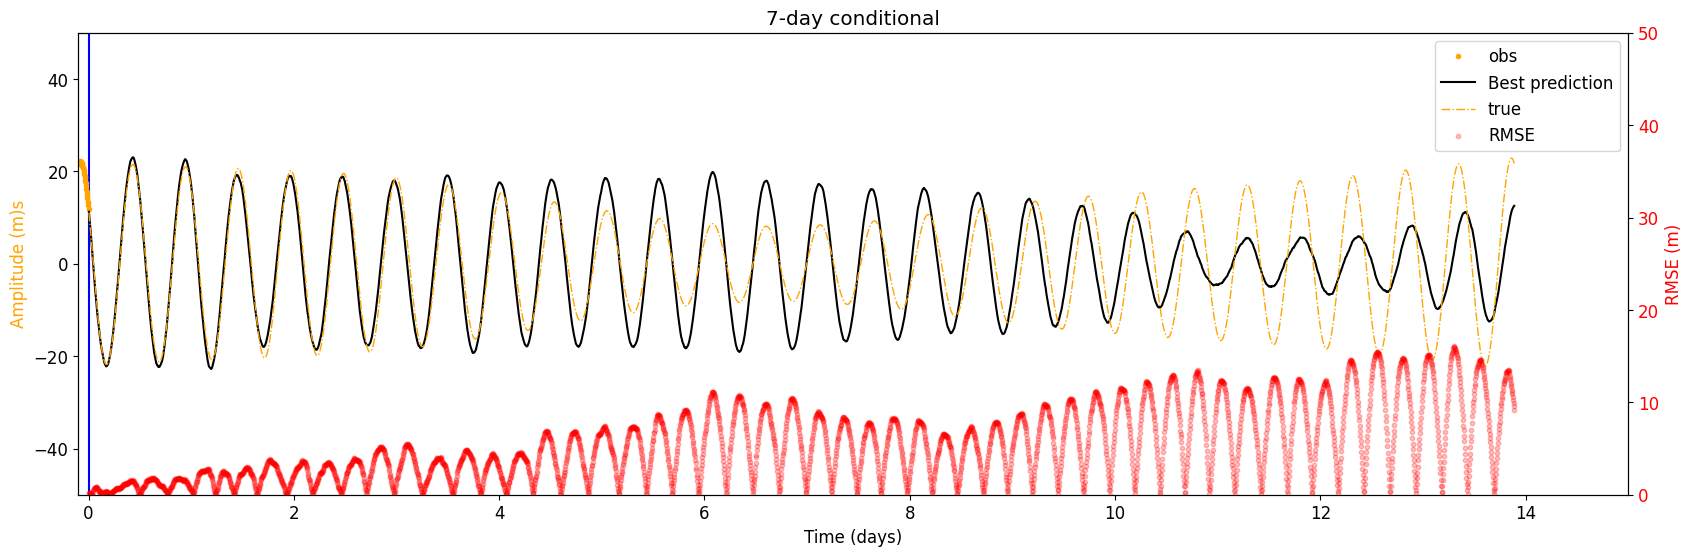

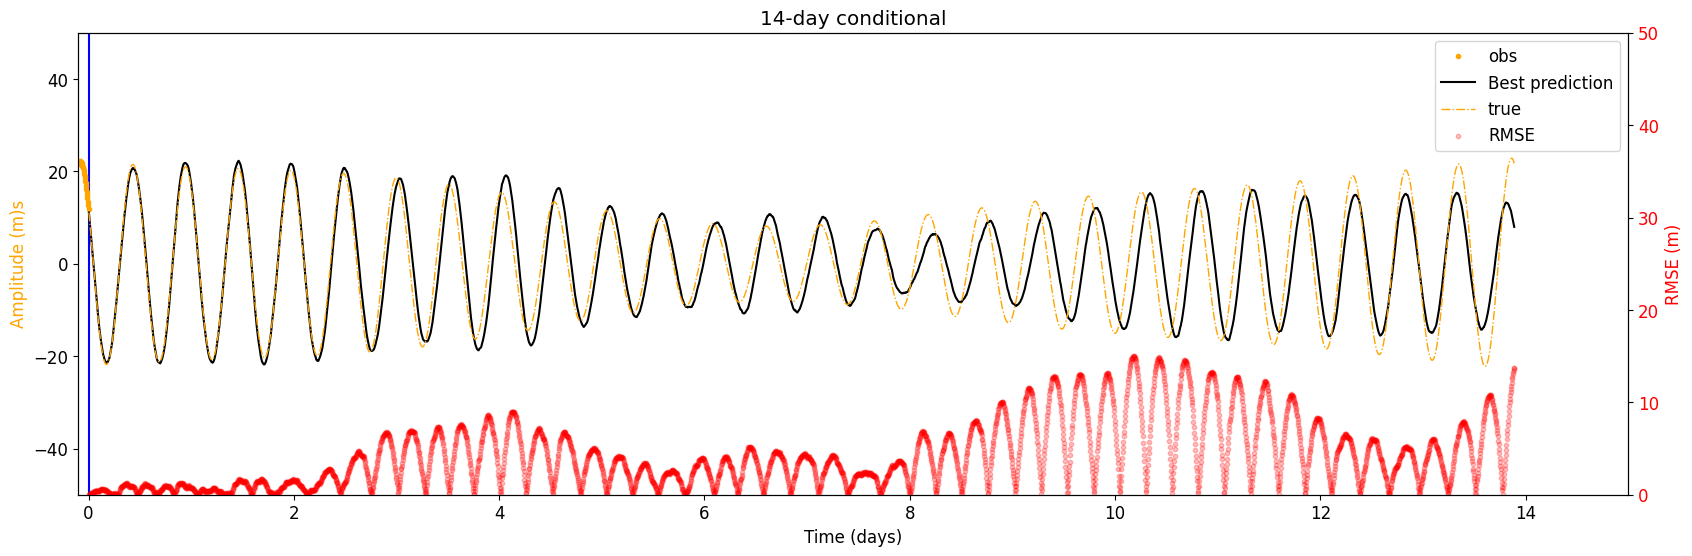

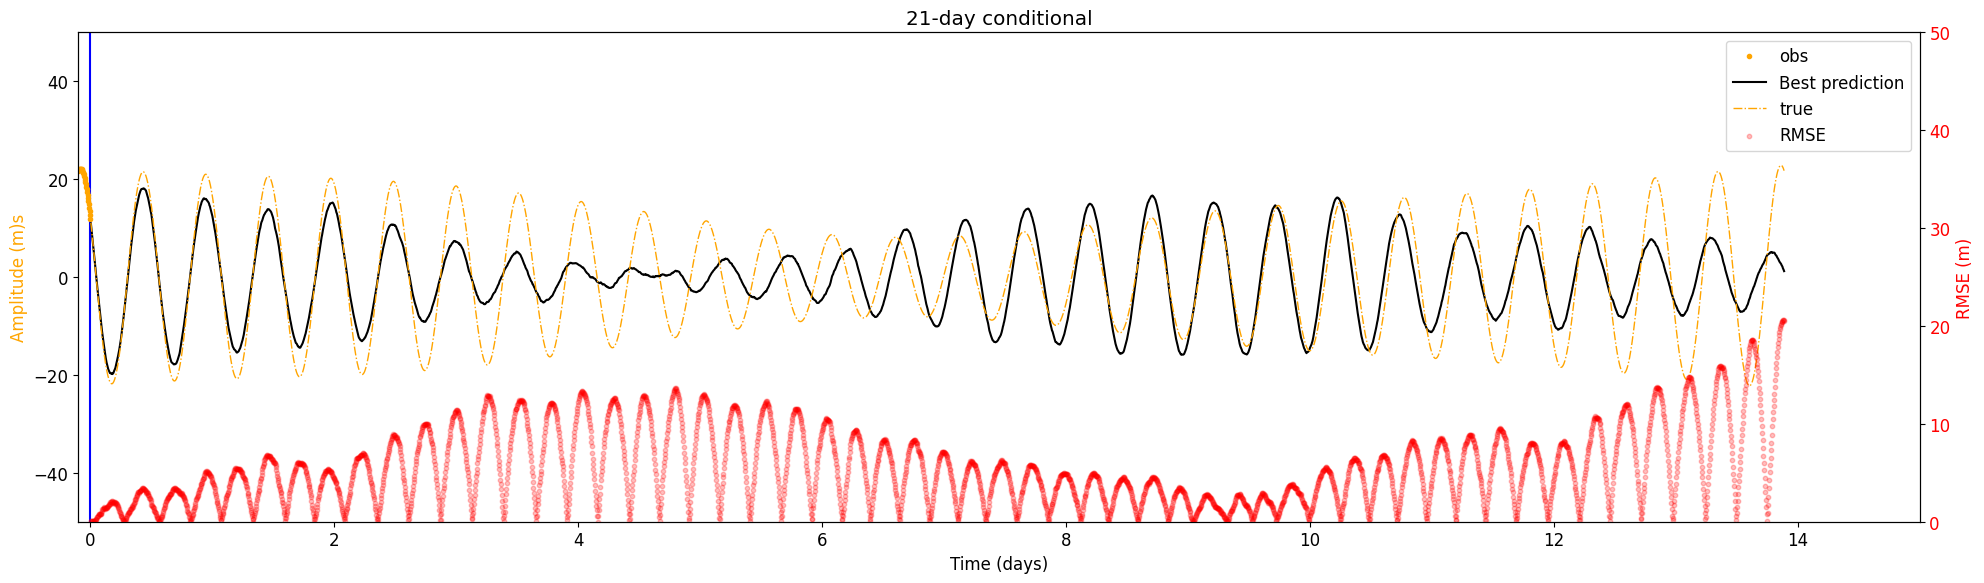

In [65]:
# Plot best prediction with RMSE
datasets = [(GP_P2_predict_dataset_7,  x_obs_7,  y_obs_7,  x_true_7,  y_true_7,  "7-day conditional"),
            (GP_P2_predict_dataset_14, x_obs_14, y_obs_14, x_true_14, y_true_14, "14-day conditional"),
            (GP_P2_predict_dataset_21, x_obs_21, y_obs_21, x_true_21, y_true_21, "21-day conditional"),]
# Loop over each dataset
for dataset, x_obs, y_obs, x_true, y_true, label in datasets:
    fig, ax = Plot_figure.Plot_best_prediction_sample(dataset, x_obs, y_obs, x_true, y_true,
                                                      amplitude_ylim=(-50, 50), figsize=(20, 6))
    ax.set_xlim(-0.1, 15)
    ax.set_title(f"{label}")
plt.tight_layout()
plt.show()

### Summary: Plots of Skill Scores

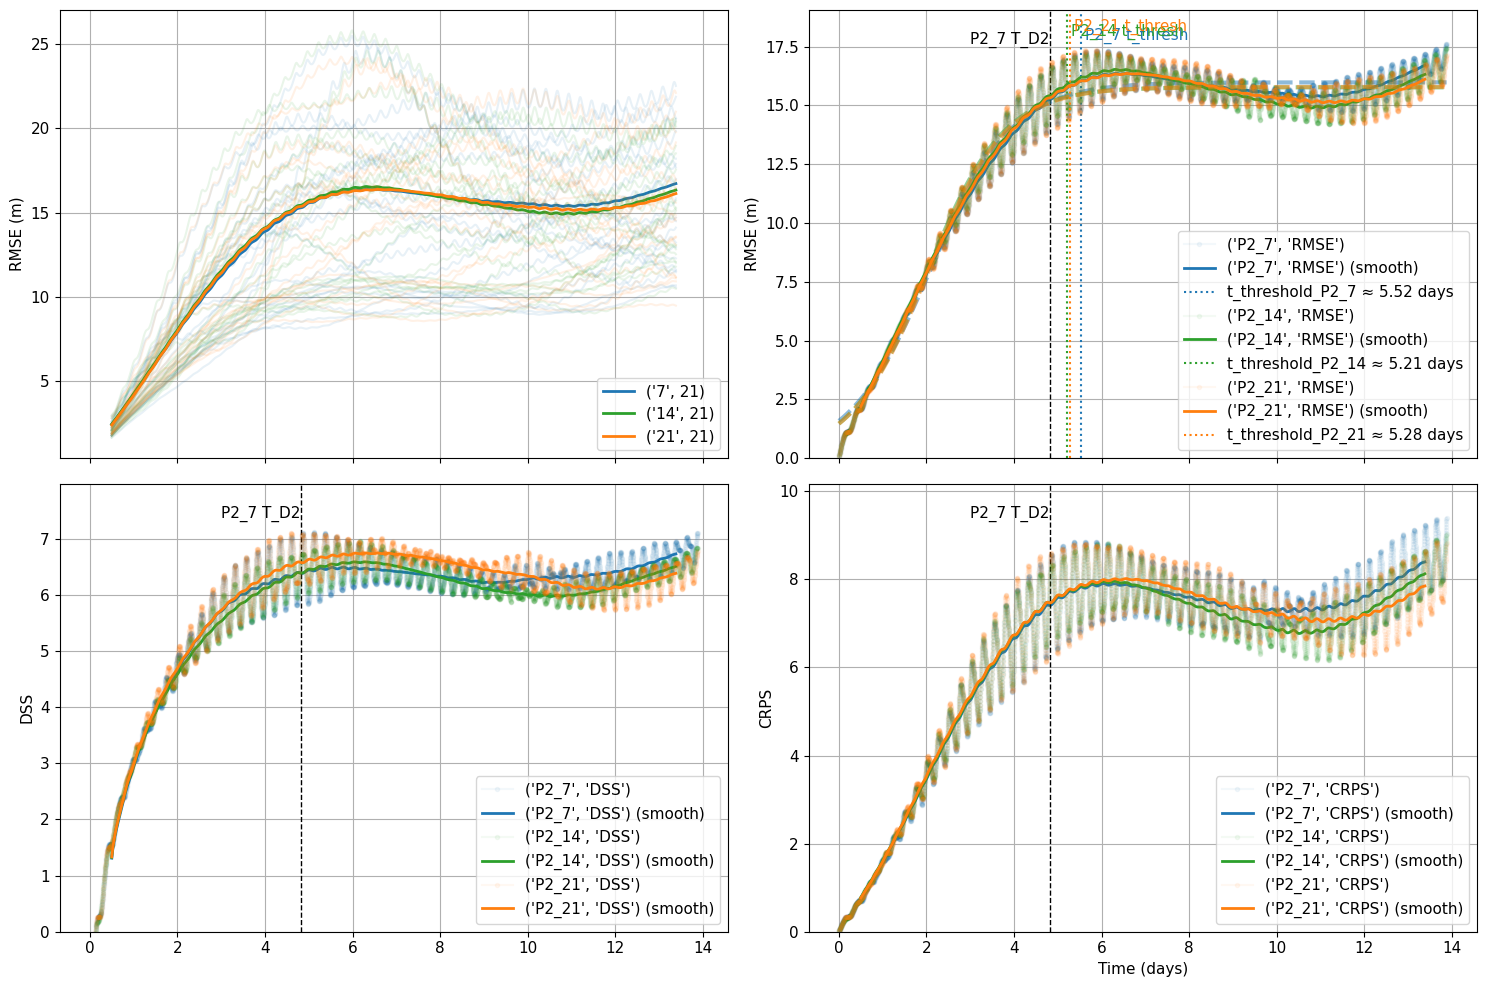

In [67]:
plt.rcParams['font.size'] = 11
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), sharex=True)
# === RMSE ===
MSE_list_NWSBRW_P2_7  = Plot_figure.Plot_RMSE(SE_list_NWSBRW_P2_7, x_true_7, window_length=1,
                               label_prefix="7", ax=axes[0,0], line_color='tab:blue')
MSE_list_NWSBRW_P2_14 = Plot_figure.Plot_RMSE(SE_list_NWSBRW_P2_14, x_true_14, window_length=1,
                               label_prefix="14", ax=axes[0,0], line_color='tab:green')
MSE_list_NWSBRW_P2_21  = Plot_figure.Plot_RMSE(SE_list_NWSBRW_P2_21, x_true_21, window_length=1,
                               label_prefix="21", ax=axes[0,0], line_color='tab:orange')
# === RMSE ===
Plot_figure.Plot_skill(MSE_list_NWSBRW_P2_7, x_true,site="NWSBRW", medium_T=medium_T_P2,
                       mode=1, window_length=1, label_prefix="P2_7", 
                       ax=axes[0,1], line_color='tab:blue')
Plot_figure.Plot_log_fit(MSE_list_NWSBRW_P2_7, x_true, label_prefix="P2_7", 
                         ax=axes[0,1], line_color='tab:blue')
Plot_figure.Plot_skill(MSE_list_NWSBRW_P2_14, x_true_14 ,site="NWSBRW", medium_T=medium_T_P2,
                       mode=1, window_length=1, label_prefix="P2_14",
                       ax=axes[0,1], line_color='tab:green',)
Plot_figure.Plot_log_fit(MSE_list_NWSBRW_P2_14, x_true_14, label_prefix="P2_14", 
                         ax=axes[0,1], line_color='tab:green')
Plot_figure.Plot_skill(MSE_list_NWSBRW_P2_21, x_true_21,site="NWSBRW", medium_T=medium_T_P2,
                       mode=1, window_length=1, label_prefix="P2_21", 
                       ax=axes[0,1], line_color='tab:orange',)
Plot_figure.Plot_log_fit(MSE_list_NWSBRW_P2_21, x_true_21, label_prefix="P2_21", 
                         ax=axes[0,1], line_color='tab:orange')
axes[0,1].set_ylabel('RMSE (m)')
# === DSS ===
Plot_figure.Plot_skill(DSS_list_NWSBRW_P2_7, x_true,site="NWSBRW", medium_T=medium_T_P2,skill_type='DSS',
                       mode=1, window_length=1,label_prefix="P2_7", 
                       ax=axes[1,0], line_color='tab:blue')
Plot_figure.Plot_skill(DSS_list_NWSBRW_P2_14, x_true_14 ,site="NWSBRW", medium_T=medium_T_P2,skill_type='DSS',
                       mode=1, window_length=1, label_prefix="P2_14",
                       ax=axes[1,0], line_color='tab:green',)
Plot_figure.Plot_skill(DSS_list_NWSBRW_P2_21, x_true_21,site="NWSBRW", medium_T=medium_T_P2,skill_type='DSS',
                       mode=1, window_length=1, label_prefix="P2_21", 
                       ax=axes[1,0], line_color='tab:orange',)
axes[1,0].set_ylabel('DSS')
# === CRPS ===
Plot_figure.Plot_skill(CRPS_list_NWSBRW_P2_7, x_true,site="NWSBRW", medium_T=medium_T_P2,skill_type='CRPS', 
                       mode=1, window_length=1,label_prefix="P2_7", 
                       ax=axes[1,1], line_color='tab:blue')
Plot_figure.Plot_skill(CRPS_list_NWSBRW_P2_14, x_true_14 ,site="NWSBRW", medium_T=medium_T_P2,skill_type='CRPS', 
                       mode=1, window_length=1, label_prefix="P2_14",
                       ax=axes[1,1], line_color='tab:green',)
Plot_figure.Plot_skill(CRPS_list_NWSBRW_P2_21, x_true_21,site="NWSBRW", medium_T=medium_T_P2,skill_type='CRPS', 
                       mode=1, window_length=1, label_prefix="P2_21", 
                       ax=axes[1,1], line_color='tab:orange',)
axes[1,1].set_ylabel('CRPS')
# Final touches
axes[1,1].set_xlabel('Time (days)')
plt.tight_layout()
plt.show()

###  P1

In [69]:
NWSBRW_covparams = list(medium_τ_P1.loc[("NWSBRW", 1)]) #mode 0'
NWSBRW_covparams

[9.5323481406, 4.2420986761, 1.8269349745]

#### 21-day

In [71]:
# Prediction Set-up 
obs_length = 6000    # ~ 21 days
total_length = 10000 # ~ 35 day
frequency_scale  = 1 # no scale
sample_number = 25   # number of prediction sample

the observation period is 20.833333333333332 days
prediction interval is 300.0 s
the prediction is for 13.88888888888889 days
the prediction is the 99 samples of the posterior + mean
Prediction is done


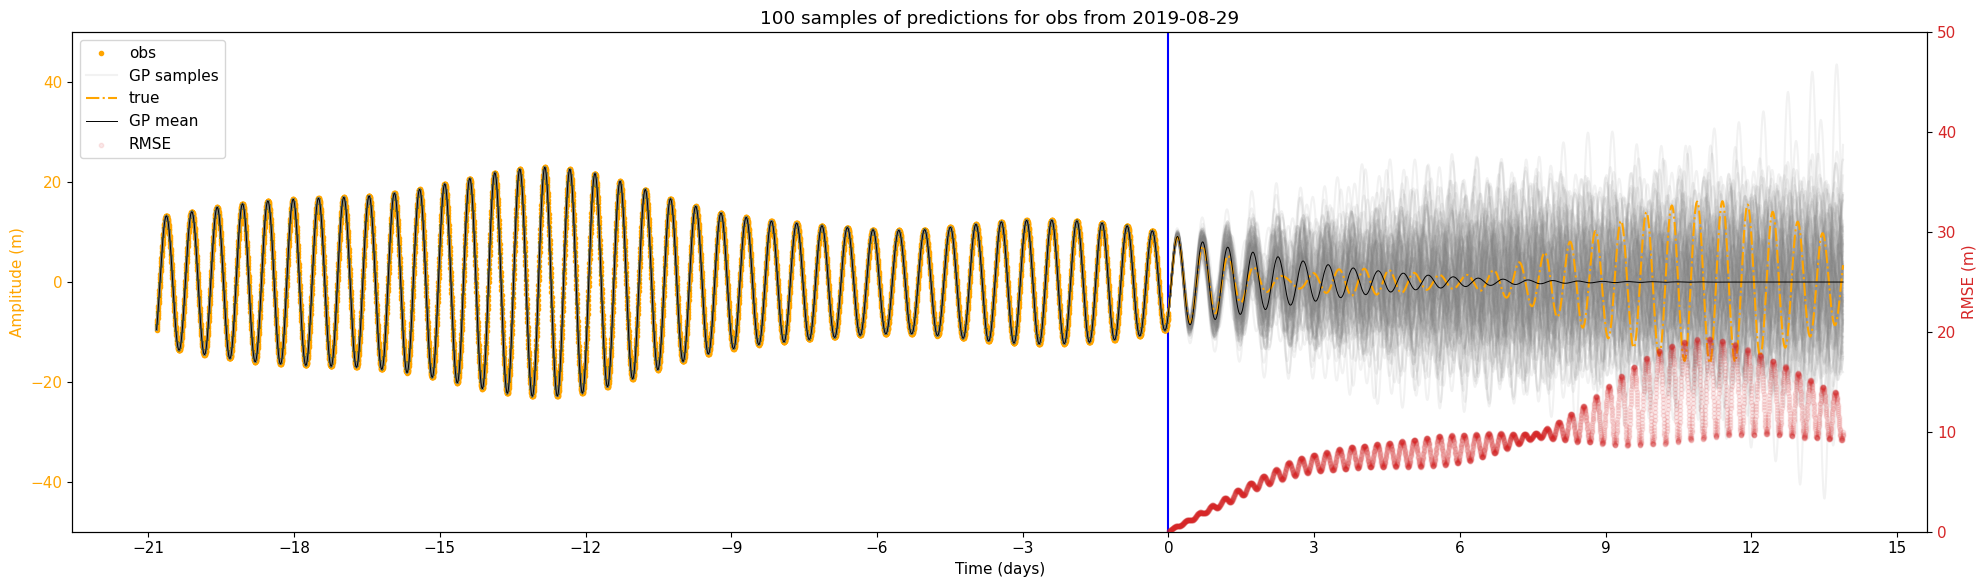

In [72]:
A_obs = sample_NWSBRW[10]
x_obs_21,y_obs_21,x_true_21,y_true_21, GP_P1_predict_dataset_21 = GP.Predicting(A_obs, obs_length, total_length,
                                                                   NWSBRW_covparams,P1_GP, mean_func,mean_params,
                                                                   sample_number= 100, noise = 0,error_threshold=100, freq_scale=frequency_scale)
#plot
Plot_figure.Plot_predictions_with_RMSE(GP_P1_predict_dataset_21,x_obs_21,y_obs_21,x_true_21,y_true_21,
                                       amplitude_ylim=(-50, 50), figsize=(20, 6))
plt.show()

In [73]:
#repeat for all 
SE_list_NWSBRW_P1_21 = []
DSS_list_NWSBRW_P1_21 = []
CRPS_list_NWSBRW_P1_21 = []
for A_obs in sample_NWSBRW:
    try:
        x_obs_21,y_obs_21,x_true_21,y_true_21, GP_P1_predict_dataset_21 = GP.Predicting(A_obs, obs_length, total_length,
                                                                              NWSBRW_covparams, P1_GP, mean_func, mean_params,
                                                                              sample_number=50, noise=0, freq_scale=frequency_scale )
        if GP_P1_predict_dataset_21 is not None:
            SE_list = Skill.Cal_skill(y_true_21,x_obs_21,GP_P1_predict_dataset_21,skill_type='SE')
            SE_list_NWSBRW_P1_21.append(SE_list)
            DSS_List = Skill.Cal_skill(y_true_21,x_obs_21,GP_P1_predict_dataset_21,skill_type='DSS')
            DSS_list_NWSBRW_P1_21.append(DSS_List)
            CRPS_List = Skill.Cal_skill(y_true_21,x_obs_21,GP_P1_predict_dataset_21,skill_type='CRPS')
            CRPS_list_NWSBRW_P1_21.append(CRPS_List)  
            # Plot_figure.Plot_predictions_with_RMSE(GP_P1_predict_dataset_21,x_obs_21,y_obs_21,x_true_21,y_true_21,
            #                            amplitude_ylim=(-75, 75), figsize=(20, 6))
        else:
            print('Predictions are completed and stop')
            
    except Exception as e:
        print(f"Skipping due to error: {e}")

the observation period is 20.833333333333332 days
prediction interval is 300.0 s
the prediction is for 13.88888888888889 days
the prediction is the 49 samples of the posterior + mean
Prediction is done
the observation period is 20.833333333333332 days
prediction interval is 300.0 s
the prediction is for 13.88888888888889 days
the prediction is the 49 samples of the posterior + mean
Bad prediction: MAE = 12.50, Max Error = 36.80 (threshold 35)
Predictions are completed and stop
the observation period is 20.833333333333332 days
prediction interval is 300.0 s
the prediction is for 13.88888888888889 days
the prediction is the 49 samples of the posterior + mean
Bad prediction: MAE = 16.72, Max Error = 38.16 (threshold 35)
Predictions are completed and stop
the observation period is 20.833333333333332 days
prediction interval is 300.0 s
the prediction is for 13.88888888888889 days
the prediction is the 49 samples of the posterior + mean
Prediction is done
the observation period is 20.8333333

#### 14-day

the observation period is 13.888888888888888 days
prediction interval is 300.0 s
the prediction is for 13.888888888888888 days
the prediction is the 99 samples of the posterior + mean
Prediction is done


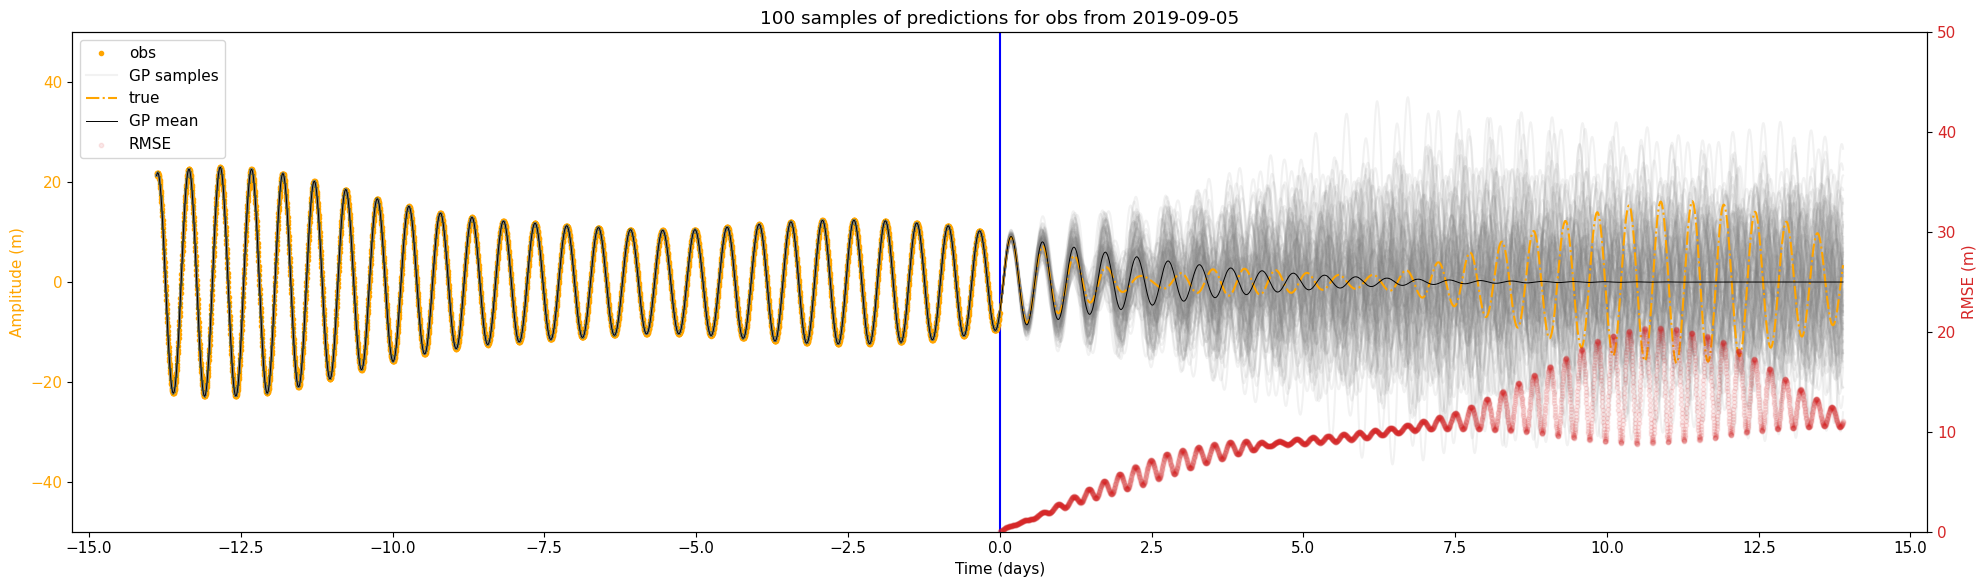

In [75]:
# prediction set up
obs_length = 4000    # 14-day 
total_length = 10000 # 
A_obs = sample_NWSBRW[10]
total_length = total_length - 2000
x_obs_14,y_obs_14,x_true_14,y_true_14, GP_P1_predict_dataset_14 = GP.Predicting(A_obs[2000:], obs_length, total_length,
                                                                   NWSBRW_covparams,P1_GP, mean_func,mean_params,
                                                                   sample_number= 100, noise = 0,error_threshold=100, freq_scale=frequency_scale)

#plot
# Plot Prediction and Skilla
from functions import Plot_figure
importlib.reload(Plot_figure)
Plot_figure.Plot_predictions_with_RMSE(GP_P1_predict_dataset_14,x_obs_14,y_obs_14,x_true_14,y_true_14,
                                       amplitude_ylim=(-50, 50), figsize=(20, 6))
plt.show()

In [76]:
#repeat for all 
SE_list_NWSBRW_P1_14 = []
DSS_list_NWSBRW_P1_14 = []
CRPS_list_NWSBRW_P1_14 = []
for A_obs in sample_NWSBRW:
    try:
        x_obs_14,y_obs_14,x_true_14,y_true_14, GP_P1_predict_dataset_14 = GP.Predicting(A_obs[2000:], obs_length, total_length,
                                                                              NWSBRW_covparams, P1_GP, mean_func, mean_params,
                                                                              sample_number=50, noise=0, freq_scale=frequency_scale )
        if GP_P1_predict_dataset_14 is not None:
            SE_list = Skill.Cal_skill(y_true_14,x_obs_14,GP_P1_predict_dataset_14,skill_type='SE')
            SE_list_NWSBRW_P1_14.append(SE_list)
            DSS_List = Skill.Cal_skill(y_true_14,x_obs_14,GP_P1_predict_dataset_14,skill_type='DSS')
            DSS_list_NWSBRW_P1_14.append(DSS_List)
            CRPS_List = Skill.Cal_skill(y_true_14,x_obs_14,GP_P1_predict_dataset_14,skill_type='CRPS')
            CRPS_list_NWSBRW_P1_14.append(CRPS_List)  
            # Plot_figure.Plot_predictions_with_RMSE(GP_P1_predict_dataset_14,x_obs_14,y_obs_14,x_true_14,y_true_14,
            #                            amplitude_ylim=(-75, 75), figsize=(20, 6))
        else:
            print('Predictions are completed and stop')
            
    except Exception as e:
        print(f"Skipping obs_start_idx due to error: {e}")

the observation period is 13.888888888888888 days
prediction interval is 300.0 s
the prediction is for 13.888888888888888 days
the prediction is the 49 samples of the posterior + mean
Prediction is done
the observation period is 13.888888888888888 days
prediction interval is 300.0 s
the prediction is for 13.888888888888888 days
the prediction is the 49 samples of the posterior + mean
Bad prediction: MAE = 12.50, Max Error = 36.80 (threshold 35)
Predictions are completed and stop
the observation period is 13.888888888888888 days
prediction interval is 300.0 s
the prediction is for 13.888888888888888 days
the prediction is the 49 samples of the posterior + mean
Bad prediction: MAE = 16.72, Max Error = 38.16 (threshold 35)
Predictions are completed and stop
the observation period is 13.888888888888888 days
prediction interval is 300.0 s
the prediction is for 13.888888888888888 days
the prediction is the 49 samples of the posterior + mean
Prediction is done
the observation period is 13.888

#### 7-day

the observation period is 6.944444444444444 days
prediction interval is 300.0 s
the prediction is for 13.88888888888889 days
the prediction is the 99 samples of the posterior + mean
Prediction is done


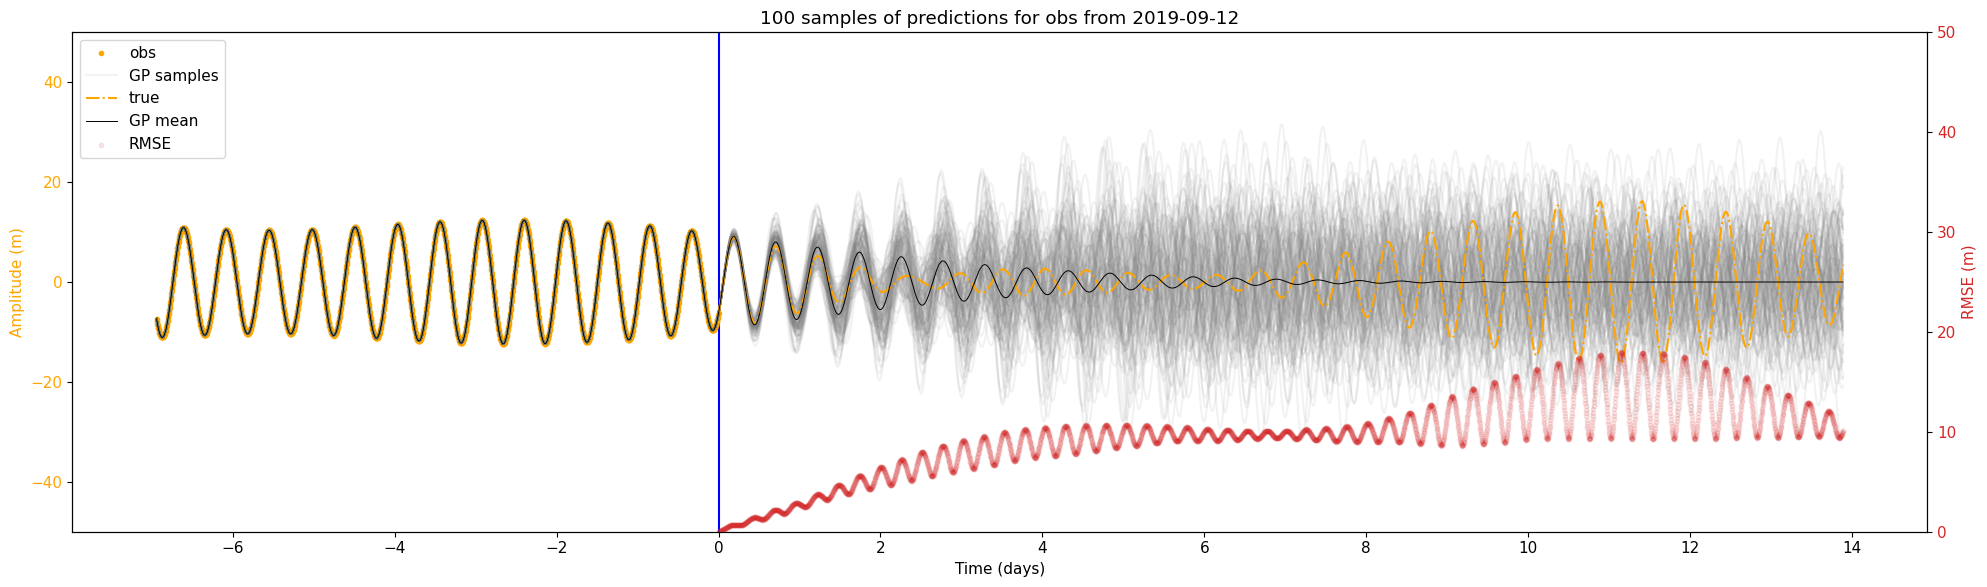

In [78]:
A_obs = sample_NWSBRW[10]
obs_length = 2000 # ~7 days
total_length = 10000
total_length = total_length - 4000
x_obs_7,y_obs_7,x_true_7,y_true_7, GP_P1_predict_dataset_7 = GP.Predicting(A_obs[4000:], obs_length, total_length,
                                                                   NWSBRW_covparams,P1_GP, mean_func,mean_params,
                                                                   sample_number= 100, noise = 0,error_threshold=100, freq_scale=frequency_scale)
# Plot Prediction with RMSE
Plot_figure.Plot_predictions_with_RMSE(GP_P1_predict_dataset_7,x_obs_7,y_obs_7,x_true_7,y_true_7,
                                       amplitude_ylim=(-50, 50), figsize=(20, 6))
plt.show()

In [79]:
#repeat for all 
SE_list_NWSBRW_P1_7 = []
DSS_list_NWSBRW_P1_7 = []
CRPS_list_NWSBRW_P1_7 = []
for A_obs in sample_NWSBRW:
    try:
        x_obs_7,y_obs_7,x_true_7,y_true_7, GP_P1_predict_dataset_7 = GP.Predicting(A_obs[4000:], obs_length, total_length,
                                                                              NWSBRW_covparams, P1_GP, mean_func, mean_params,
                                                                              sample_number=50, noise=0, freq_scale=frequency_scale )
        if GP_P1_predict_dataset_7 is not None:
            SE_list = Skill.Cal_skill(y_true_7,x_obs_7,GP_P1_predict_dataset_7,skill_type='SE')
            SE_list_NWSBRW_P1_7.append(SE_list)
            DSS_List = Skill.Cal_skill(y_true_7,x_obs_7,GP_P1_predict_dataset_7,skill_type='DSS')
            DSS_list_NWSBRW_P1_7.append(DSS_List)
            CRPS_List = Skill.Cal_skill(y_true_7,x_obs_7,GP_P1_predict_dataset_7,skill_type='CRPS')
            CRPS_list_NWSBRW_P1_7.append(CRPS_List)  
            # Plot_figure.Plot_predictions_with_RMSE(GP_P1_predict_dataset_7,x_obs_7,y_obs_7,x_true_7,y_true_7,
            #                            amplitude_ylim=(-75, 75), figsize=(20, 6))
        else:
            print('Predictions are completed and stop')
            
    except Exception as e:
        print(f"Skipping obs_start_idx due to error: {e}")

the observation period is 6.944444444444444 days
prediction interval is 300.0 s
the prediction is for 13.88888888888889 days
the prediction is the 49 samples of the posterior + mean
Prediction is done
the observation period is 6.944444444444444 days
prediction interval is 300.0 s
the prediction is for 13.88888888888889 days
the prediction is the 49 samples of the posterior + mean
Bad prediction: MAE = 12.50, Max Error = 36.80 (threshold 35)
Predictions are completed and stop
the observation period is 6.944444444444444 days
prediction interval is 300.0 s
the prediction is for 13.88888888888889 days
the prediction is the 49 samples of the posterior + mean
Bad prediction: MAE = 16.72, Max Error = 38.15 (threshold 35)
Predictions are completed and stop
the observation period is 6.944444444444444 days
prediction interval is 300.0 s
the prediction is for 13.88888888888889 days
the prediction is the 49 samples of the posterior + mean
Prediction is done
the observation period is 6.944444444444

#### Summary: Plots of Best Prediction

Best sample index: 32
Best sample index: 37
Best sample index: 35


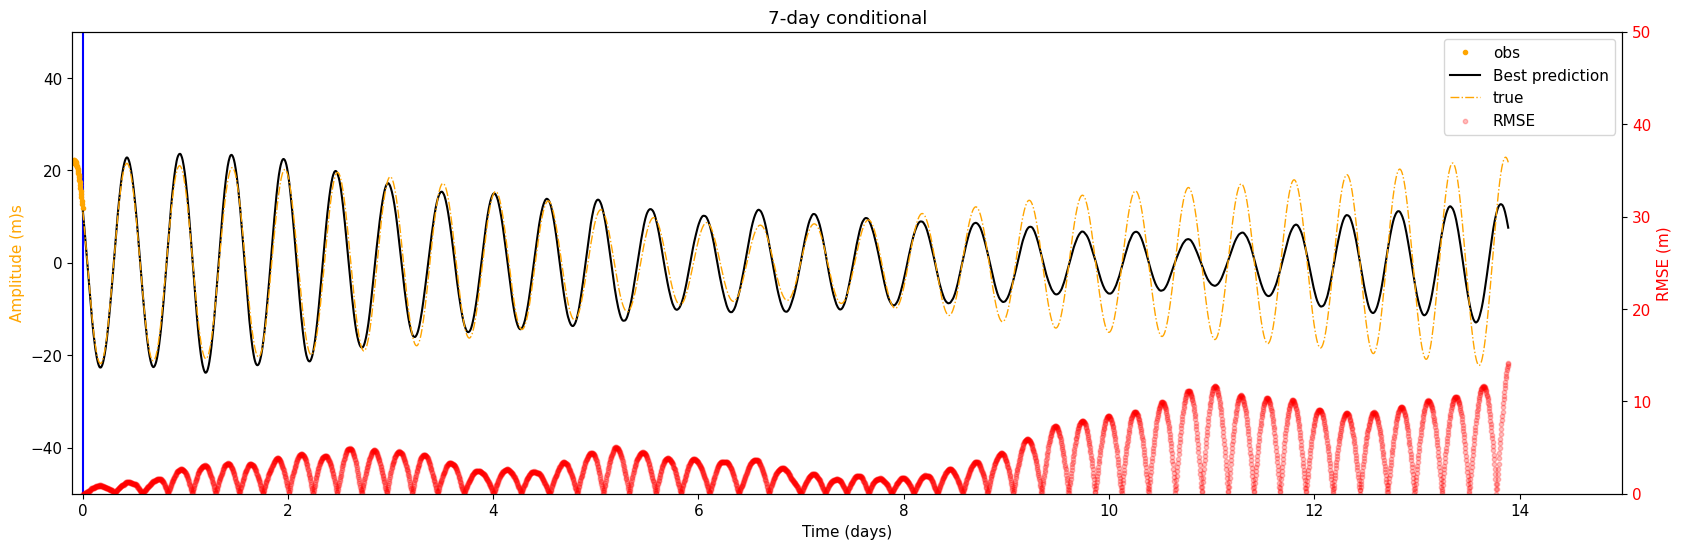

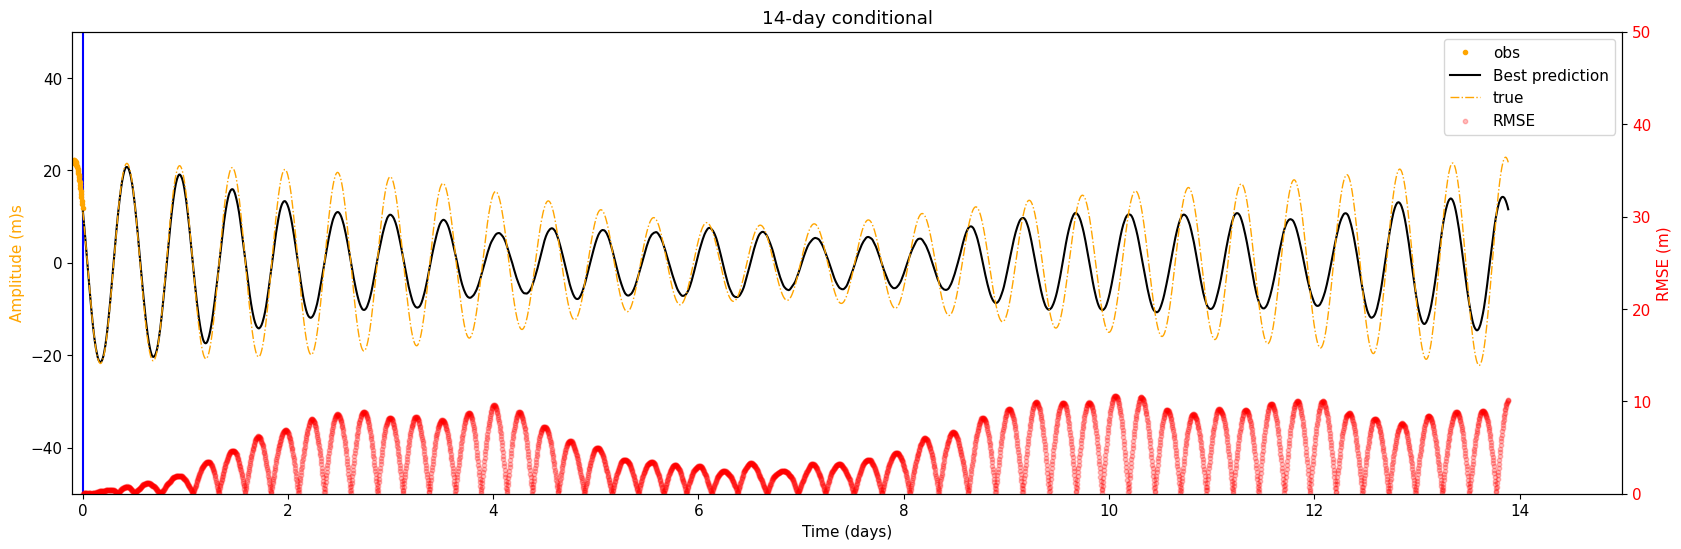

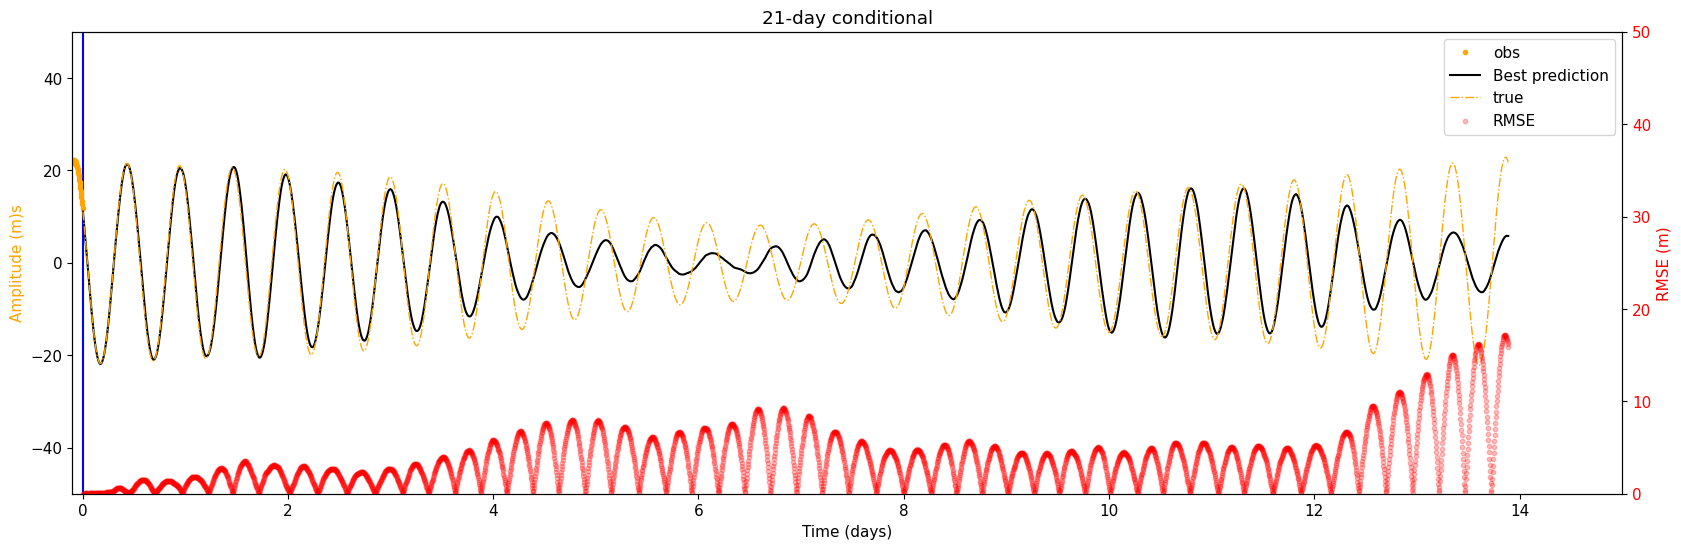

In [81]:
importlib.reload(Plot_figure)
# List of datasets and their corresponding lead times
datasets = [(GP_P1_predict_dataset_7,  x_obs_7,  y_obs_7,  x_true_7,  y_true_7,  "7-day conditional"),
            (GP_P1_predict_dataset_14, x_obs_14, y_obs_14, x_true_14, y_true_14, "14-day conditional"),
            (GP_P1_predict_dataset_21, x_obs_21, y_obs_21, x_true_21, y_true_21, "21-day conditional"),]
# Loop over each dataset
for dataset, x_obs, y_obs, x_true, y_true, label in datasets:
    fig, ax = Plot_figure.Plot_best_prediction_sample(dataset, x_obs, y_obs, x_true, y_true,
                                                      amplitude_ylim=(-50, 50), figsize=(20, 6))
    ax.set_xlim(-0.1, 15)
    ax.set_title(f"{label}")
plt.show()

#### Summary: Plots of Skill Scores

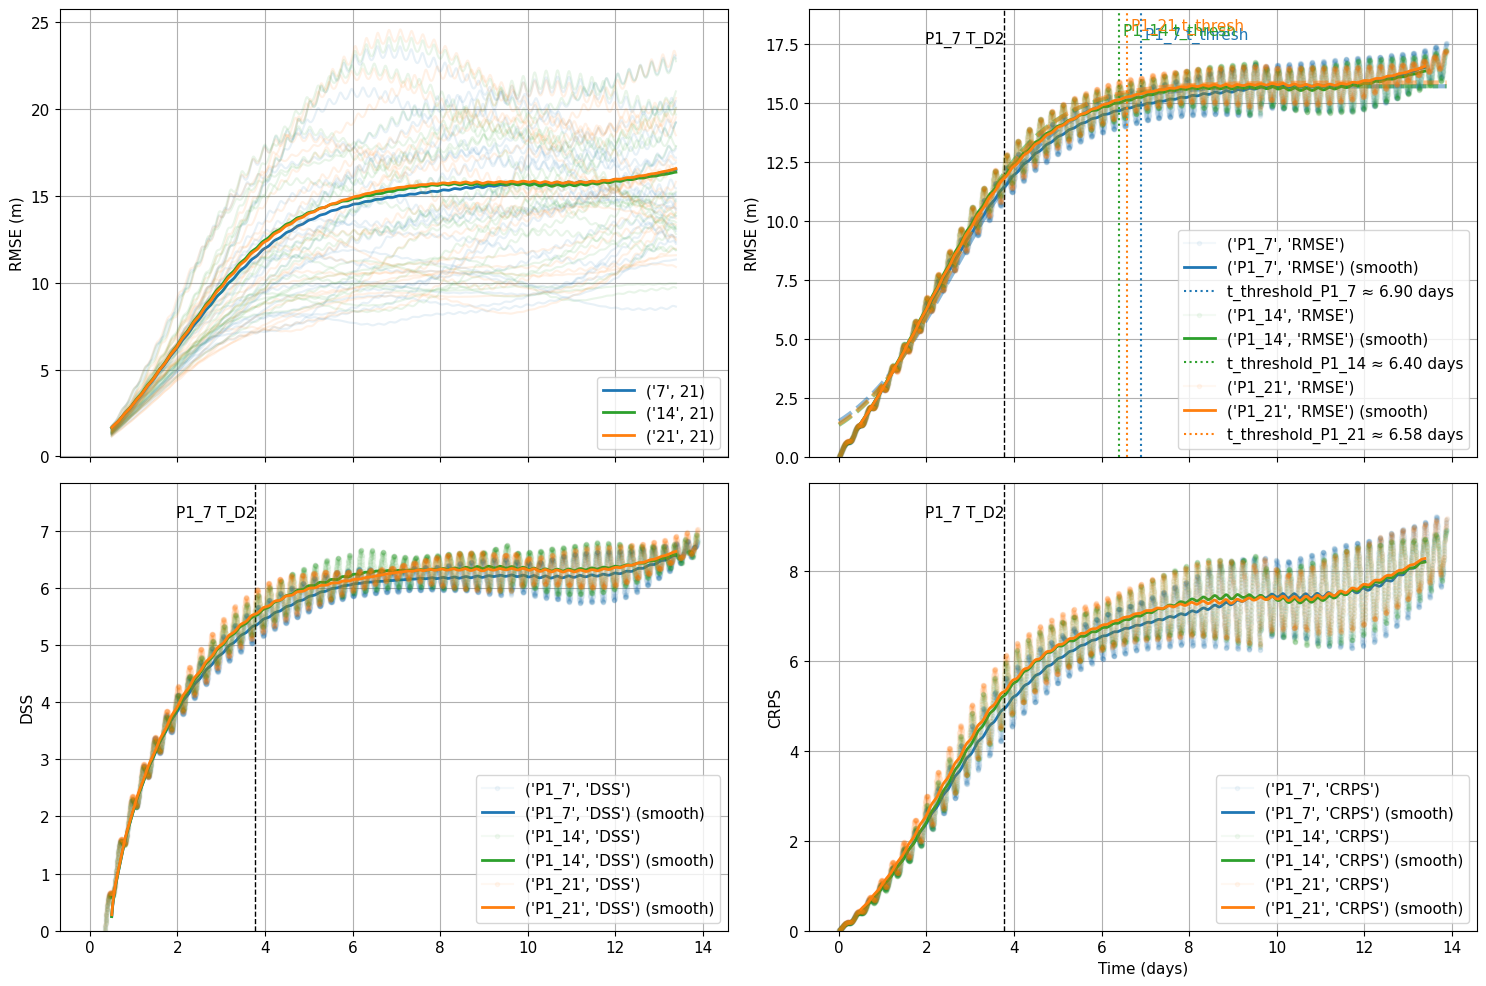

In [83]:
plt.rcParams['font.size'] = 11
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), sharex=True)

# === RMSE ===
MSE_list_NWSBRW_P1_7  = Plot_figure.Plot_RMSE(SE_list_NWSBRW_P1_7, x_true_7, window_length=1,
                               label_prefix="7", ax=axes[0,0], line_color='tab:blue')
MSE_list_NWSBRW_P1_14 = Plot_figure.Plot_RMSE(SE_list_NWSBRW_P1_14, x_true_14, window_length=1,
                               label_prefix="14", ax=axes[0,0], line_color='tab:green')
MSE_list_NWSBRW_P1_21  = Plot_figure.Plot_RMSE(SE_list_NWSBRW_P1_21, x_true_21, window_length=1,
                               label_prefix="21", ax=axes[0,0], line_color='tab:orange')
# === RMSE ===
Plot_figure.Plot_skill(MSE_list_NWSBRW_P1_7, x_true,site="NWSBRW", medium_T=medium_T_P1,
                       mode=1, window_length=1, label_prefix="P1_7", 
                       ax=axes[0,1], line_color='tab:blue')
Plot_figure.Plot_log_fit(MSE_list_NWSBRW_P1_7, x_true, label_prefix="P1_7", ax=axes[0,1], line_color='tab:blue')
Plot_figure.Plot_skill(MSE_list_NWSBRW_P1_14, x_true_14 ,site="NWSBRW", medium_T=medium_T_P1,
                       mode=1, window_length=1, label_prefix="P1_14",
                       ax=axes[0,1], line_color='tab:green',)
Plot_figure.Plot_log_fit(MSE_list_NWSBRW_P1_14, x_true_14, label_prefix="P1_14", ax=axes[0,1], line_color='tab:green')
Plot_figure.Plot_skill(MSE_list_NWSBRW_P1_21, x_true_21,site="NWSBRW", medium_T=medium_T_P1,
                       mode=1, window_length=1, label_prefix="P1_21", 
                       ax=axes[0,1], line_color='tab:orange',)
Plot_figure.Plot_log_fit(MSE_list_NWSBRW_P1_21, x_true_21, label_prefix="P1_21",  ax=axes[0,1], line_color='tab:orange')
axes[0,1].set_ylabel('RMSE (m)')


# === DSS ===
Plot_figure.Plot_skill(DSS_list_NWSBRW_P1_7, x_true,site="NWSBRW", medium_T=medium_T_P1,skill_type='DSS',
                       mode=1, window_length=1,label_prefix="P1_7", 
                       ax=axes[1,0], line_color='tab:blue')
Plot_figure.Plot_skill(DSS_list_NWSBRW_P1_14, x_true_14 ,site="NWSBRW", medium_T=medium_T_P1,skill_type='DSS',
                       mode=1, window_length=1, label_prefix="P1_14",
                       ax=axes[1,0], line_color='tab:green',)
Plot_figure.Plot_skill(DSS_list_NWSBRW_P1_21, x_true_21,site="NWSBRW", medium_T=medium_T_P1,skill_type='DSS',
                       mode=1, window_length=1, label_prefix="P1_21", 
                       ax=axes[1,0], line_color='tab:orange',)
axes[1,0].set_ylabel('DSS')

# === CRPS ===
Plot_figure.Plot_skill(CRPS_list_NWSBRW_P1_7, x_true,site="NWSBRW", medium_T=medium_T_P1,skill_type='CRPS', 
                       mode=1, window_length=1,label_prefix="P1_7", 
                       ax=axes[1,1], line_color='tab:blue')
Plot_figure.Plot_skill(CRPS_list_NWSBRW_P1_14, x_true_14 ,site="NWSBRW", medium_T=medium_T_P1,skill_type='CRPS', 
                       mode=1, window_length=1, label_prefix="P1_14",
                       ax=axes[1,1], line_color='tab:green',)
Plot_figure.Plot_skill(CRPS_list_NWSBRW_P1_21, x_true_21,site="NWSBRW", medium_T=medium_T_P1,skill_type='CRPS', 
                       mode=1, window_length=1, label_prefix="P1_21", 
                       ax=axes[1,1], line_color='tab:orange',)

axes[1,1].set_ylabel('CRPS')
# Final touches
axes[1,1].set_xlabel('Time (days)')
plt.tight_layout()
plt.show()

### P2 vs P1

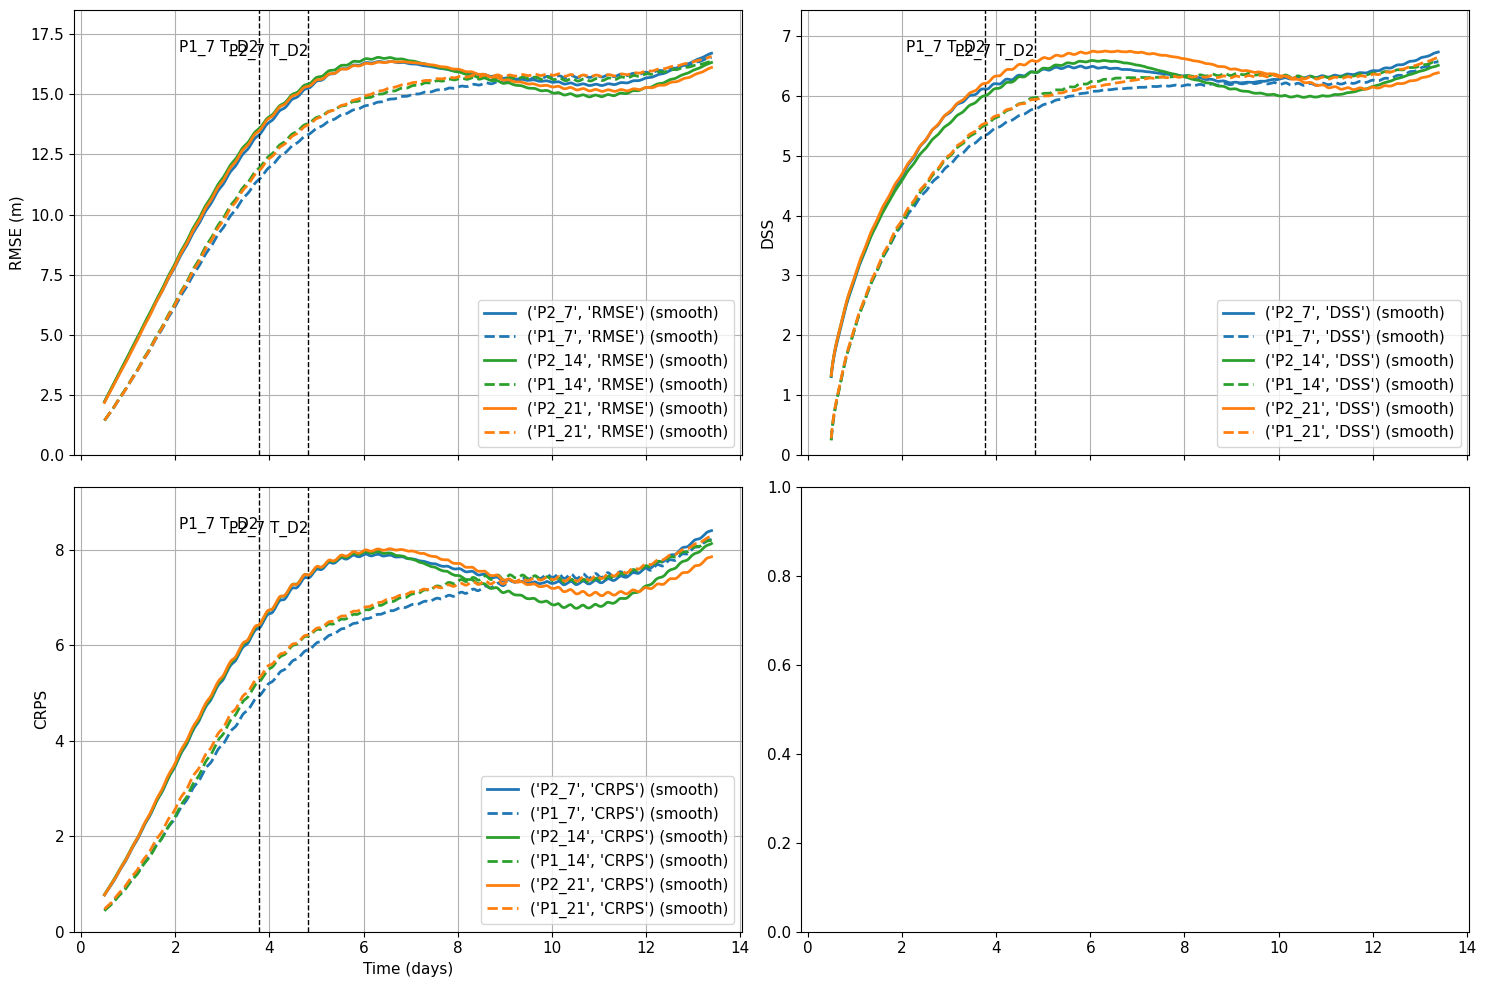

In [85]:
plt.rcParams['font.size'] = 11
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 10), sharex=True)

# # === RMSE ===
# MSE_list_NWSBRW_P2_7  = Plot_figure.Plot_RMSE(SE_list_NWSBRW_P2_7, x_true_7, window_length=1,
#                                label_prefix="7", ax=axes[0,0], line_color='tab:blue')
# MSE_list_NWSBRW_P2_14 = Plot_figure.Plot_RMSE(SE_list_NWSBRW_P2_14, x_true_14, window_length=1,
#                                label_prefix="14", ax=axes[0,0], line_color='tab:green')
# MSE_list_NWSBRW_P2_21  = Plot_figure.Plot_RMSE(SE_list_NWSBRW_P2_21, x_true_21, window_length=1,
#                                label_prefix="21", ax=axes[0,0], line_color='tab:orange')
# === RMSE ===
Plot_figure.Plot_skill(MSE_list_NWSBRW_P2_7, x_true,site="NWSBRW", medium_T=medium_T_P2,
                       mode=1, window_length=1, label_prefix="P2_7", 
                       ax=axes[0,0], line_color='tab:blue',line_style ='-',raw_plot=False)
Plot_figure.Plot_skill(MSE_list_NWSBRW_P1_7, x_true,site="NWSBRW", medium_T=medium_T_P1,
                       mode=1, window_length=1, label_prefix="P1_7", 
                       ax=axes[0,0], line_color='tab:blue',line_style ='--',raw_plot=False)
Plot_figure.Plot_skill(MSE_list_NWSBRW_P2_14, x_true_14 ,site="NWSBRW", medium_T=medium_T_P2,
                       mode=1, window_length=1, label_prefix="P2_14",
                       ax=axes[0,0], line_color='tab:green',line_style ='-',raw_plot=False)
Plot_figure.Plot_skill(MSE_list_NWSBRW_P1_14, x_true_14 ,site="NWSBRW", medium_T=medium_T_P1,
                       mode=1, window_length=1, label_prefix="P1_14",
                       ax=axes[0,0], line_color='tab:green',line_style ='--',raw_plot=False)
Plot_figure.Plot_skill(MSE_list_NWSBRW_P2_21, x_true_21,site="NWSBRW", medium_T=medium_T_P2,
                       mode=1, window_length=1, label_prefix="P2_21", 
                       ax=axes[0,0], line_color='tab:orange',line_style ='-',raw_plot=False)
Plot_figure.Plot_skill(MSE_list_NWSBRW_P1_21, x_true_21,site="NWSBRW", medium_T=medium_T_P1,
                       mode=1, window_length=1, label_prefix="P1_21", 
                       ax=axes[0,0], line_color='tab:orange',line_style ='--',raw_plot=False)                      
axes[0,0].set_ylabel('RMSE (m)')
# # === DSS ===
Plot_figure.Plot_skill(DSS_list_NWSBRW_P2_7, x_true,site="NWSBRW", medium_T=medium_T_P2,skill_type='DSS',
                       mode=1, window_length=1, label_prefix="P2_7", 
                       ax=axes[0,1], line_color='tab:blue',line_style ='-',raw_plot=False)
Plot_figure.Plot_skill(DSS_list_NWSBRW_P1_7, x_true,site="NWSBRW", medium_T=medium_T_P1,skill_type='DSS',
                       mode=1, window_length=1, label_prefix="P1_7", 
                       ax=axes[0,1], line_color='tab:blue',line_style ='--',raw_plot=False)
Plot_figure.Plot_skill(DSS_list_NWSBRW_P2_14, x_true_14 ,site="NWSBRW", medium_T=medium_T_P2,skill_type='DSS',
                       mode=1, window_length=1, label_prefix="P2_14",
                       ax=axes[0,1], line_color='tab:green',line_style ='-',raw_plot=False)
Plot_figure.Plot_skill(DSS_list_NWSBRW_P1_14, x_true_14 ,site="NWSBRW", medium_T=medium_T_P1,skill_type='DSS',
                       mode=1, window_length=1, label_prefix="P1_14",
                       ax=axes[0,1], line_color='tab:green',line_style ='--',raw_plot=False)
Plot_figure.Plot_skill(DSS_list_NWSBRW_P2_21, x_true_21,site="NWSBRW", medium_T=medium_T_P2,skill_type='DSS',
                       mode=1, window_length=1, label_prefix="P2_21", 
                       ax=axes[0,1], line_color='tab:orange',line_style ='-',raw_plot=False)
Plot_figure.Plot_skill(DSS_list_NWSBRW_P1_21, x_true_21,site="NWSBRW", medium_T=medium_T_P1,skill_type='DSS',
                       mode=1, window_length=1, label_prefix="P1_21", 
                       ax=axes[0,1], line_color='tab:orange',line_style ='--',raw_plot=False)      
axes[0,1].set_ylabel('DSS')
# # === CRPS ===
Plot_figure.Plot_skill(CRPS_list_NWSBRW_P2_7, x_true,site="NWSBRW", medium_T=medium_T_P2,skill_type='CRPS', 
                       mode=1, window_length=1, label_prefix="P2_7", 
                       ax=axes[1,0], line_color='tab:blue',line_style ='-',raw_plot=False)
Plot_figure.Plot_skill(CRPS_list_NWSBRW_P1_7, x_true,site="NWSBRW", medium_T=medium_T_P1,skill_type='CRPS', 
                       mode=1, window_length=1, label_prefix="P1_7", 
                       ax=axes[1,0], line_color='tab:blue',line_style ='--',raw_plot=False)
Plot_figure.Plot_skill(CRPS_list_NWSBRW_P2_14, x_true_14 ,site="NWSBRW", medium_T=medium_T_P2,skill_type='CRPS', 
                       mode=1, window_length=1, label_prefix="P2_14",
                       ax=axes[1,0], line_color='tab:green',line_style ='-',raw_plot=False)
Plot_figure.Plot_skill(CRPS_list_NWSBRW_P1_14, x_true_14 ,site="NWSBRW", medium_T=medium_T_P1,skill_type='CRPS', 
                       mode=1, window_length=1, label_prefix="P1_14",
                       ax=axes[1,0], line_color='tab:green',line_style ='--',raw_plot=False)
Plot_figure.Plot_skill(CRPS_list_NWSBRW_P2_21, x_true_21,site="NWSBRW", medium_T=medium_T_P2,skill_type='CRPS', 
                       mode=1, window_length=1, label_prefix="P2_21", 
                       ax=axes[1,0], line_color='tab:orange',line_style ='-',raw_plot=False)
Plot_figure.Plot_skill(CRPS_list_NWSBRW_P1_21, x_true_21,site="NWSBRW", medium_T=medium_T_P1,skill_type='CRPS', 
                       mode=1, window_length=1, label_prefix="P1_21", 
                       ax=axes[1,0], line_color='tab:orange',line_style ='--',raw_plot=False)                   
axes[1,0].set_ylabel('CRPS')
# Final touches
axes[1,0].set_xlabel('Time (days)')
plt.tight_layout()
plt.show()